# AgPV Index
Exploratory data analysis for creation of an AG PV index: a composite scoring metric to identify USA counties with high cobenefits potential for agrivoltaics

* Data inputs: solar supply, weather hazards, energy burden, minority owned cropland

## Data Processing
Things to do:

* ~aggregate NREL's solar supply data by county~
* ~get relevant weather hazards data from csv file (hail and drought are positives, tornado is negative.)~
    * might start ith overall agriculture burden for positives first
* ~load energy burden data~
* ~get minoirty owned data from R2R indices to start~
* Estimate fraction of energy coops in county
    * from Energy Information Administration. Need to combine several of provided datasets:
    * Power generated/customers served by each utility, Counties each utility services, FIPS info
* Suitable crops for ag pv
* [True land footprint of solar energy](https://betterenergy.org/blog/the-true-land-footprint-of-solar-energy/)
* 8-year slope values for each state's electricity (quads)
* C-intensity of electricity for most recent year (2022) divided by the electricity (quads)
 

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from usda_qwikstats_utils import usda_qwikstats_utils
from config import usda_qwik_stats_key

data_dir = 'AgPV_data'

# USDA Qwik stats
Crops like beets, tomatoes, peppers, and leafy greens seem to do well with agPV. e want to find counties with high amounts/percentages of crop area for these crops (beets, potatoes, radishes, tomatoes, peppers, carrots, spinach, lettuce, all berries, goats, and sheep)

May have to calculate livestock and crops seperately. I believe crops can be measured in area, but livestock might be measured in heads.



In [28]:
veggie_commodities = ['beets', 'potatoes', 'radishes', 'tomatoes', 'peppers', 'carrots', 'spinach', 'lettuce']

usda_search_params = {'year':'2022',
                              'agg_level':'county',
                              'source_desc':'census',
                              'statisticcat_desc': 'Area Harvested',
                              'format':'JSON'}

usda_utils = usda_qwikstats_utils(usda_qwik_stats_key)

def get_usda_dfs(commodity: str, search_params:dict = usda_search_params, usda_utils:usda_qwikstats_utils = usda_utils) -> pd.DataFrame:
    '''Returns pandas df for the commodity searched for'''
    print(f'Getting {commodity.title()} Data...')
    
    params_copy = search_params
    
    if 'commodity_desc' not in params_copy.keys():
        params_copy['commodity_desc'] = commodity
        
    # make api call
    r = usda_utils.get_qwikstats_data(params_copy)
    
    
    try:
        data = r.json()['data']
        return pd.DataFrame(data)
    
    except Exception as e:
        print(e)
        print(r.text)


veggies_dfs = [get_usda_dfs(commodity) for commodity in veggie_commodities]

veggies_df = pd.concat(veggies_dfs)
veggies_df.head()

Getting Beets Data...
https://quickstats.nass.usda.gov/api/api_GET/?key=597B6B3C-1DD4-377F-AE50-97B64E360F41&year=2022&agg_level=county&source_desc=census&statisticcat_desc=Area Harvested&format=JSON&commodity_desc=beets
Getting Potatoes Data...
https://quickstats.nass.usda.gov/api/api_GET/?key=597B6B3C-1DD4-377F-AE50-97B64E360F41&year=2022&agg_level=county&source_desc=census&statisticcat_desc=Area Harvested&format=JSON&commodity_desc=beets
Getting Radishes Data...
https://quickstats.nass.usda.gov/api/api_GET/?key=597B6B3C-1DD4-377F-AE50-97B64E360F41&year=2022&agg_level=county&source_desc=census&statisticcat_desc=Area Harvested&format=JSON&commodity_desc=beets
Getting Tomatoes Data...
https://quickstats.nass.usda.gov/api/api_GET/?key=597B6B3C-1DD4-377F-AE50-97B64E360F41&year=2022&agg_level=county&source_desc=census&statisticcat_desc=Area Harvested&format=JSON&commodity_desc=beets
Getting Peppers Data...
https://quickstats.nass.usda.gov/api/api_GET/?key=597B6B3C-1DD4-377F-AE50-97B64E360

<bound method NDFrame.head of      reference_period_desc zip_5       prodn_practice_desc state_ansi  \
0                     YEAR        ALL PRODUCTION PRACTICES              
1                     YEAR        ALL PRODUCTION PRACTICES              
2                     YEAR        ALL PRODUCTION PRACTICES              
3                     YEAR        ALL PRODUCTION PRACTICES              
4                     YEAR        ALL PRODUCTION PRACTICES              
...                    ...   ...                       ...        ...   
6465                  YEAR        ALL PRODUCTION PRACTICES         22   
6466                  YEAR        ALL PRODUCTION PRACTICES         35   
6467                  YEAR        ALL PRODUCTION PRACTICES         23   
6468                  YEAR        ALL PRODUCTION PRACTICES         48   
6469                  YEAR        ALL PRODUCTION PRACTICES         51   

             util_practice_desc  group_desc asd_code                load_time  \
0     ALL UT

In [11]:
veggies_df[veggies_df['agg_level_desc'] == 'COUNTY'].head()

state_ansi         util_practice_desc asd_code  group_desc  \
7          01  ALL UTILIZATION PRACTICES       10  VEGETABLES   
8          01  ALL UTILIZATION PRACTICES       10  VEGETABLES   
9          01  ALL UTILIZATION PRACTICES       10  VEGETABLES   
10         01  ALL UTILIZATION PRACTICES       20  VEGETABLES   
11         01  ALL UTILIZATION PRACTICES       20  VEGETABLES   

         prodn_practice_desc zip_5 reference_period_desc county_ansi  \
7   ALL PRODUCTION PRACTICES                        YEAR         077   
8   ALL PRODUCTION PRACTICES                        YEAR         079   
9   ALL PRODUCTION PRACTICES                        YEAR         103   
10  ALL PRODUCTION PRACTICES                        YEAR         019   
11  ALL PRODUCTION PRACTICES                        YEAR         049   

   agg_level_desc domaincat_desc  ... congr_district_code commodity_desc  \
7          COUNTY  NOT SPECIFIED  ...                              BEETS   
8          COUNTY  NOT SPECIFIED  ...                              BEETS   
9          COUNTY  NOT SPECIFIED  ...                              BEETS   
10         COUNTY  NOT SPECIFIED  ...                              BEETS   
11         COUNTY  NOT SPECIFIED  ...                              BEETS   

                   Value  end_code week_ending domain_desc  \
7                      1        00                   TOTAL   
8                    (D)        00                   TOTAL   
9                      1        00                   TOTAL   
10                   (D)        00                   TOTAL   
11                   (D)        00                   TOTAL   

                                    location_desc   country_name begin_code  \
7            ALABAMA, NORTHERN VALLEY, LAUDERDALE  UNITED STATES         00   
8              ALABAMA, NORTHERN VALLEY, LAWRENCE  UNITED STATES         00   
9                ALABAMA, NORTHERN VALLEY, MORGAN  UNITED STATES         00   
10  ALABAMA, MOUNTAINS & EASTERN VALLEY, CHEROKEE  UNITED STATES         00   
11   ALABAMA, MOUNTAINS & EASTERN VALLEY, DE KALB  UNITED STATES         00   

   freq_desc  
7     ANNUAL  
8     ANNUAL  
9     ANNUAL  
10    ANNUAL  
11    ANNUAL  

[5 rows x 39 columns]

### Berries
Berries have a different format

In [21]:
berry_search_params = {'year':'2022',
                              'agg_level':'county',
                              'source_desc':'census',
                              'statisticcat_desc_LIKE': 'ACRES GROWN',
                              'format':'JSON'}

berry_search_params['commodity_desc'] = 'Berry Totals'

r = usda_utils.get_qwikstats_data(berry_search_params)

berries_df = pd.DataFrame(r.json()['data'])
berries_df.head()

https://quickstats.nass.usda.gov/api/api_GET/?key=597B6B3C-1DD4-377F-AE50-97B64E360F41&year=2022&agg_level=county&source_desc=census&statisticcat_desc_LIKE=ACRES GROWN&format=JSON&commodity_desc=Berry Totals


country_name begin_code week_ending end_code    Value location_desc  \
0  UNITED STATES         00                   00    3,936      US TOTAL   
1  UNITED STATES         00                   00   16,232      US TOTAL   
2  UNITED STATES         00                   00  184,974      US TOTAL   
3  UNITED STATES         00                   00   14,011      US TOTAL   
4  UNITED STATES         00                   00   21,893      US TOTAL   

  domain_desc freq_desc sector_desc congr_district_code  ... asd_code  \
0  AREA GROWN    ANNUAL       CROPS                      ...            
1  AREA GROWN    ANNUAL       CROPS                      ...            
2  AREA GROWN    ANNUAL       CROPS                      ...            
3  AREA GROWN    ANNUAL       CROPS                      ...            
4  AREA GROWN    ANNUAL       CROPS                      ...            

          util_practice_desc state_ansi       prodn_practice_desc unit_desc  \
0  ALL UTILIZATION PRACTICES             ALL PRODUCTION PRACTICES     ACRES   
1  ALL UTILIZATION PRACTICES             ALL PRODUCTION PRACTICES     ACRES   
2  ALL UTILIZATION PRACTICES             ALL PRODUCTION PRACTICES     ACRES   
3  ALL UTILIZATION PRACTICES             ALL PRODUCTION PRACTICES     ACRES   
4  ALL UTILIZATION PRACTICES             ALL PRODUCTION PRACTICES     ACRES   

  state_name                load_time agg_level_desc  county_ansi  \
0   US TOTAL  2024-07-02 12:00:00.000       NATIONAL                
1   US TOTAL  2024-07-02 12:00:00.000       NATIONAL                
2   US TOTAL  2024-07-02 12:00:00.000       NATIONAL                
3   US TOTAL  2024-07-02 12:00:00.000       NATIONAL                
4   US TOTAL  2024-07-02 12:00:00.000       NATIONAL                

                     domaincat_desc  
0    AREA GROWN: (0.1 TO 0.9 ACRES)  
1    AREA GROWN: (1.0 TO 4.9 ACRES)  
2   AREA GROWN: (100 OR MORE ACRES)  
3  AREA GROWN: (15.0 TO 24.9 ACRES)  
4  AREA GROWN: (25.0 TO 49.9 ACRES)  

[5 rows x 39 columns]

### Goats and Sheep
Goats and sheep only have inventory (num of goats/sheep) at the county level

In [68]:
sheep_goats_path = '68E1129D-0FD5-3FC4-A812-EF6D3EBE6718.csv'

sheep_goats_df = pd.read_csv(os.path.join(data_dir, sheep_goats_path))
sheep_goats_df.head()

Program  Year Period  Week Ending Geo Level    State  State ANSI  \
0  CENSUS  2022   YEAR          NaN    COUNTY  ALABAMA           1   
1  CENSUS  2022   YEAR          NaN    COUNTY  ALABAMA           1   
2  CENSUS  2022   YEAR          NaN    COUNTY  ALABAMA           1   
3  CENSUS  2022   YEAR          NaN    COUNTY  ALABAMA           1   
4  CENSUS  2022   YEAR          NaN    COUNTY  ALABAMA           1   

  Ag District  Ag District Code   County  ...  Zip Code  Region  \
0  BLACK BELT                40  AUTAUGA  ...       NaN     NaN   
1  BLACK BELT                40  BULLOCK  ...       NaN     NaN   
2  BLACK BELT                40   DALLAS  ...       NaN     NaN   
3  BLACK BELT                40   ELMORE  ...       NaN     NaN   
4  BLACK BELT                40     HALE  ...       NaN     NaN   

   watershed_code  Watershed             Commodity  \
0               0        NaN  SHEEP & GOATS TOTALS   
1               0        NaN  SHEEP & GOATS TOTALS   
2               0        NaN  SHEEP & GOATS TOTALS   
3               0        NaN  SHEEP & GOATS TOTALS   
4               0        NaN  SHEEP & GOATS TOTALS   

                                           Data Item Domain Domain Category  \
0  SHEEP & GOATS TOTALS, INCL WOOL & MOHAIR & MIL...  TOTAL   NOT SPECIFIED   
1  SHEEP & GOATS TOTALS, INCL WOOL & MOHAIR & MIL...  TOTAL   NOT SPECIFIED   
2  SHEEP & GOATS TOTALS, INCL WOOL & MOHAIR & MIL...  TOTAL   NOT SPECIFIED   
3  SHEEP & GOATS TOTALS, INCL WOOL & MOHAIR & MIL...  TOTAL   NOT SPECIFIED   
4  SHEEP & GOATS TOTALS, INCL WOOL & MOHAIR & MIL...  TOTAL   NOT SPECIFIED   

     Value CV (%)  
0   78,000    0.1  
1   20,000    0.1  
2   11,000    0.1  
3  208,000    0.1  
4      (D)    (D)  

[5 rows x 21 columns]

In [65]:
livestock_df['unit_desc']

Index(['util_practice_desc', 'group_desc', 'asd_code', 'state_ansi',
       'prodn_practice_desc', 'zip_5', 'reference_period_desc',
       'agg_level_desc', 'county_ansi', 'domaincat_desc', 'unit_desc',
       'state_name', 'load_time', 'year', 'county_name', 'country_code',
       'asd_desc', 'class_desc', 'short_desc', 'watershed_code',
       'watershed_desc', 'statisticcat_desc', 'state_fips_code', 'source_desc',
       'state_alpha', 'county_code', 'CV (%)', 'sector_desc',
       'congr_district_code', 'region_desc', 'commodity_desc', 'week_ending',
       'end_code', 'Value', 'location_desc', 'domain_desc', 'country_name',
       'begin_code', 'freq_desc'],
      dtype='object')

### Solar Supply Data NREL

Commonly cited NREL data for solar supply. I'm aggregating this by county.

https://www.nrel.gov/gis/solar-resource-maps.html

In [2]:
# got solar supply data
solar_dir = 'solar-pv-reference-access-2023'
solar_file = 'reference_access_2030_moderate_supply-curve.csv'

solar_df = pd.read_csv(os.path.join(solar_dir, solar_file), dtype={'cnty_fips':str})
solar_df['cnty_fips'] = solar_df['cnty_fips'].apply(lambda x: x.zfill(5))

# get total for each county
location_cols = ['cnty_fips', 'county', 'state']
solar_sums_df = solar_df.groupby(location_cols, as_index=False).sum()

# I think we just need capacity_mw_ac
solar_sums_df = solar_sums_df[location_cols + ['capacity_mw_ac', 'capacity_mw_dc']]

# rename fips column
solar_sums_df = solar_sums_df.rename(columns={'cnty_fips':'FIPS'})
solar_sums_df.head()

FIPS   county    state  capacity_mw_ac  capacity_mw_dc
0  01001  Autauga  Alabama    22349.202978    29947.935193
1  01003  Baldwin  Alabama    46948.973155    62911.632997
2  01005  Barbour  Alabama    43344.657028    58081.848135
3  01007     Bibb  Alabama    28368.690972    38014.050777
4  01009   Blount  Alabama    18483.385380    24767.738851

### NRI Weather hazards data

FEMA has created weather hazard index scores for various weather hazards. Right now, I'm only focusing on how these hazards affect agricultural losses. For AgPV, tornadoes are negative, since they destroy solar panels. Drought, hail, and heatwave are positives, since AgPV can help protect crops or diversify farmer income hagainst these hazards.

Relevant columns:

* TRND_ALRA: expected tornado ag loss rate
* HWAV_ALRA: heatwave expected ag loss rate
* HAIL_ALRA: hail expected ag loss rate
* DRGT_ALRA: drought expected loss
* RESL_SCORE: community resilience score
* SOVI_SCORE: sovial vulnerability score

can use different suffixes for different metrics. Other metrics of interest:
* RISKV: risk value
* RISKS: risk index score
* RISKR: risk index rating

https://hazards.fema.gov/nri

In [3]:
nri_dir = 'NRI_Table_Counties'
nri_file = 'NRI_Table_Counties.csv'

nri_df = pd.read_csv(os.path.join(data_dir, nri_dir, nri_file), dtype={'STCOFIPS':str})

# keep relevant columns
prefixes = ['TRND', 'HWAV', 'HAIL', 'DRGT']
suffixes = ['ALRA', 'RISKV', 'RISKS']
nri_keep_cols = ['_'.join([pf, sf]) for pf in prefixes for sf in suffixes]

nri_df = nri_df[['STCOFIPS', 'RESL_SCORE', 'SOVI_SCORE'] + nri_keep_cols]

# rename relevant columns
nri_df = nri_df.rename(columns={'STCOFIPS':'FIPS'})
nri_df.head()

FIPS  RESL_SCORE  SOVI_SCORE  TRND_ALRA    TRND_RISKV  TRND_RISKS  \
0  01001   51.810001   51.299999   0.000029  2.831745e+06   73.846643   
1  01003   86.120003   31.030001   0.000004  7.982720e+06   91.377665   
2  01005    6.240000   99.269997   0.000009  2.845056e+06   73.942094   
3  01007   19.730000   80.779999   0.000067  2.609927e+06   71.969456   
4  01009   22.820000   51.369999   0.000077  6.930682e+06   89.723194   

      HWAV_ALRA    HWAV_RISKV  HWAV_RISKS     HAIL_ALRA     HAIL_RISKV  \
0  2.747418e-06  8.799794e+05   87.082405  4.687348e-05  152041.957165   
1  9.080529e-07  1.243722e+06   91.091314  2.308179e-07  124028.950214   
2  2.747418e-06  2.821581e+05   69.710468  4.524451e-06   68324.832750   
3  4.200027e-06  2.428259e+05   67.228762  2.179460e-04   81868.702495   
4  4.200027e-06  6.368582e+05   82.437162  1.966831e-05   82093.176164   

   HAIL_RISKS  DRGT_ALRA     DRGT_RISKV  DRGT_RISKS  
0   57.111040   0.000826   28542.388900   50.652243  
1   52.943048   0.003216  484573.697842   86.796055  
2   39.993637   0.001623  295053.353506   80.687241  
3   43.684378   0.000831    4764.186212   32.421254  
4   43.716195   0.000093   32581.621879   52.147630

### Energy Burden

Percent of household income spent on energy. AgPV can help high burden counties lower their energy burden.

https://www.energy.gov/scep/slsc/lead-tool

In [4]:
eburden_file = 'LEAD Tool Data Counties.csv'

eburden_df = pd.read_csv(os.path.join(data_dir, eburden_file), skiprows=range(0,8), dtype={'Geography ID':str})
eburden_df = eburden_df.rename(columns={'Geography ID':'FIPS'})
eburden_df = eburden_df[['FIPS', 'Energy Burden (% income)']]
eburden_df.head()

FIPS  Energy Burden (% income)
0  01001                         3
1  01003                         2
2  01005                         4
3  01007                         4
4  01009                         3

### R2R Data

Farmer income and % of minority owned cropland analyzed for Roads to Removal. Don't get too sad at the minority owned farm numbers.

In [5]:
farm_income_file = 'avg_farm_income.csv'

# 'Avg Farm Net Income ($)' has a bunch of wierd str values. '(D)' is undisclosed, and this messes up pandas reading it as a float
farm_income_df = pd.read_csv(os.path.join(data_dir, farm_income_file), dtype={'County ANSI':str, 'State ANSI':str, 'Avg Farm Net Income ($)':str})
farm_income_df['FIPS'] = farm_income_df.apply(lambda x: x['State ANSI'].zfill(2) + x['County ANSI'].zfill(3), axis=1)
farm_income_df = farm_income_df[['FIPS', 'Avg Farm Net Income ($)']]
farm_income_df.head()

FIPS Avg Farm Net Income ($)
0  01001                  18,279
1  01011                  71,850
2  01047                  35,071
3  01051                   9,847
4  01063                  19,870

In [6]:
# minority owned cropland
minority_crop_file = 'minority_owned_cropland_counties.csv'

min_crop_df = pd.read_csv(os.path.join(data_dir, minority_crop_file), dtype={'fips_code':str})
min_crop_df = min_crop_df.rename(columns={'fips_code':'FIPS'})
min_crop_df = min_crop_df[['FIPS', 'Percent Minority Owned']]
min_crop_df.head()

FIPS  Percent Minority Owned
0  01005                0.000000
1  01011                1.984635
2  01013                0.000000
3  01025                0.000000
4  01043                0.415887

# Energy Information Admisitration: Coop data from 2022
Counties with strong existing cooperatively owned energy generators could have a stronger foundationg for equitably adopting AgPV

Unfortunately, the data from EIA doesn't have county FIPS codes. They only have state abbreviations and county names. We'll have to do some joins to get the actual FIPS code.

In [117]:
eia_dir = 'EIA_f8612022'
meters_file = 'Advanced_Meters_2022.xlsx'
sales_file = 'Sales_Ult_Cust_2022.xlsx'
service_territory_file = 'Service_Territory_2022.xlsx'

eia_sales_df = pd.read_excel(os.path.join(data_dir, eia_dir, sales_file), header=[0,1,2], nrows=2829)
eia_locations_df = pd.read_excel(os.path.join(data_dir, eia_dir, service_territory_file))

# keep only totals column from sales
eia_sales_df = eia_sales_df.loc[:, eia_sales_df.columns.get_level_values(0).isin(['Utility Characteristics', 'TOTAL'])]
eia_sales_df.columns = eia_sales_df.columns.get_level_values(-1)
eia_sales_df = eia_locations_df[['Utility Number', 'County']].merge(eia_sales_df, on='Utility Number')

# Clean case just in case there's some shenanigans
eia_sales_df['State'] = eia_sales_df['State'].apply(lambda x: x.strip().upper())
eia_sales_df['County'] = eia_sales_df['County'].apply(lambda x: x.strip().title())

# get county geo info
state_abbrevs_file = 'us-states-territories.csv'
county_file = 'US_FIPS_Codes.xls'
state_df = pd.read_csv(os.path.join(data_dir, state_abbrevs_file), encoding='unicode_escape')
state_df['Name'] = state_df['Name'].apply(lambda x: x.strip().title())

county_df = pd.read_excel(os.path.join(data_dir, county_file), header=1, dtype={'FIPS State':str, 'FIPS County':str})
county_df['State'] = county_df['State'].apply(lambda x: x.strip().title())
county_df['FIPS'] = county_df['FIPS State'] + county_df['FIPS County']

state_county_df = state_df[['Name', 'Abbreviation', 'area (square miles)']].merge(county_df[['State', 'County Name', 'FIPS']], left_on='Name', right_on='State')
state_county_df = state_county_df[['State', 'Abbreviation', 'County Name', 'FIPS', 'area (square miles)']]

state_county_df['Abbreviation'] = state_county_df['Abbreviation'].apply(lambda x: x.strip().upper())
state_county_df['County Name'] = state_county_df['County Name'].apply(lambda x: x.strip().title())
state_county_df = state_county_df.rename(columns={'County Name':'County'})

eia_sales_df = eia_sales_df.merge(state_county_df, left_on=['State', 'County'], right_on=['Abbreviation', 'County'])
keep_cols = ['FIPS', 'Ownership', 'area (square miles)', 'Thousand Dollars', 'Megawatthours', 'Count']
eia_sales_df = eia_sales_df[keep_cols]

# get percentage of non-investor-owned energy
sales_sum_df = eia_sales_df.loc[:, ['FIPS', 'Thousand Dollars', 'Megawatthours', 'Count']].groupby('FIPS', as_index=False).sum()

eia_ownership_sales_df = eia_sales_df.loc[:, ['FIPS', 'Ownership', 'Thousand Dollars', 'Megawatthours', 'Count']].groupby(['FIPS', 'Ownership'], as_index=False).sum()
sales_sum_df = eia_ownership_sales_df.merge(sales_sum_df, on='FIPS', suffixes=('', '_total'))
sales_sum_df['Percent Megawatthours'] = 100 * sales_sum_df['Megawatthours'] / sales_sum_df['Megawatthours_total']
sales_sum_df['Percent Count'] = 100 * sales_sum_df['Count'] / sales_sum_df['Count_total']

eia_percent_df = sales_sum_df.loc[sales_sum_df['Ownership'] == 'Investor Owned', :]
eia_percent_df['Percent Non Investor Owned'] = 100 - eia_percent_df['Percent Count']
eia_percent_df = eia_percent_df[['FIPS', 'Percent Non Investor Owned']]
eia_percent_df

<ipython-input-117-bc00d10825f3>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eia_percent_df['Percent Non Investor Owned'] = 100 - eia_percent_df['Percent Count']


FIPS  Percent Non Investor Owned
1     01001                    2.942734
3     01003                    9.632698
6     01005                    4.668915
8     01007                    2.942734
9     01009                    0.000000
...     ...                         ...
5286  56037                    0.003478
5289  56039                   22.753224
5290  56041                    0.000000
5293  56043                    8.685847
5295  56045                   91.119574

[2262 rows x 2 columns]

## Merge all DFs together

In [181]:
all_dfs = [solar_sums_df, nri_df, eburden_df, farm_income_df, min_crop_df, eia_percent_df]
all_dfs = [df.set_index('FIPS') for df in all_dfs]
merged_df = pd.concat(all_dfs, axis=1)
merged_df = merged_df.dropna(subset=['county'])

# percent minority owned has lots of missing data (due to a lack of minority owned cropland!) This means NaNs are effectivey 0
merged_df['Percent Minority Owned'] = merged_df['Percent Minority Owned'].fillna(0)
merged_df['Percent Non Investor Owned'] = merged_df['Percent Non Investor Owned'].fillna(0)

# clean farm income data. This column is the messiest
def clean_farm_income(x):
    if isinstance(x, float):
        return x
    
    if x.strip() == '(D)':
        return np.nan
    
    else:
        return float(x.replace(',', ''))
    
def fill_na_max(ser: pd.Series):
    return ser.fillna(ser.max())
            
merged_df['Avg Farm Net Income ($)'] = merged_df['Avg Farm Net Income ($)'].apply(clean_farm_income)

# fill undefined rows (nan entries) with max value. This is most conservative estimate
merged_df['Avg Farm Net Income ($)'] = fill_na_max(merged_df['Avg Farm Net Income ($)'])

# identify counties with negative net income
merged_df['Negative Net Farm Income'] = merged_df['Avg Farm Net Income ($)'].apply(lambda x: 1 if x < 0 else 0)

merged_df

county    state  capacity_mw_ac  capacity_mw_dc  RESL_SCORE  \
FIPS                                                                     
01001     Autauga  Alabama    22349.202978    29947.935193   51.810001   
01003     Baldwin  Alabama    46948.973155    62911.632997   86.120003   
01005     Barbour  Alabama    43344.657028    58081.848135    6.240000   
01007        Bibb  Alabama    28368.690972    38014.050777   19.730000   
01009      Blount  Alabama    18483.385380    24767.738851   22.820000   
...           ...      ...             ...             ...         ...   
56037  Sweetwater  Wyoming   401041.398994   537395.558058   30.709999   
56039       Teton  Wyoming     4915.661374     6586.986832   39.529999   
56041       Uinta  Wyoming    83816.558073   112314.202527   27.820000   
56043    Washakie  Wyoming    72277.627225    96852.034274   62.029999   
56045      Weston  Wyoming   155044.608219   207759.812413    9.740000   

       SOVI_SCORE  TRND_ALRA    TRND_RISKV  TRND_RISKS     HWAV_ALRA  ...  \
FIPS                                                                  ...   
01001   51.299999   0.000029  2.831745e+06   73.846643  2.747418e-06  ...   
01003   31.030001   0.000004  7.982720e+06   91.377665  9.080529e-07  ...   
01005   99.269997   0.000009  2.845056e+06   73.942094  2.747418e-06  ...   
01007   80.779999   0.000067  2.609927e+06   71.969456  4.200027e-06  ...   
01009   51.369999   0.000077  6.930682e+06   89.723194  4.200027e-06  ...   
...           ...        ...           ...         ...           ...  ...   
56037   37.400002   0.000002  6.773591e+04   10.531339  0.000000e+00  ...   
56039   19.190001   0.000015  2.501826e+05   21.189946  0.000000e+00  ...   
56041   40.639999   0.000002  9.517126e+04   12.567611  0.000000e+00  ...   
56043   26.610001   0.000009  1.060502e+05   13.013045  0.000000e+00  ...   
56045   23.200001   0.000037  3.330118e+05   24.657970  0.000000e+00  ...   

          HAIL_RISKV  HAIL_RISKS  DRGT_ALRA     DRGT_RISKV  DRGT_RISKS  \
FIPS                                                                     
01001  152041.957165   57.111040   0.000826   28542.388900   50.652243   
01003  124028.950214   52.943048   0.003216  484573.697842   86.796055   
01005   68324.832750   39.993637   0.001623  295053.353506   80.687241   
01007   81868.702495   43.684378   0.000831    4764.186212   32.421254   
01009   82093.176164   43.716195   0.000093   32581.621879   52.147630   
...              ...         ...        ...            ...         ...   
56037    2120.127461    3.340757   0.000181    3696.294806   29.812281   
56039   66342.791859   39.102768   0.000056    1075.132966   21.539930   
56041   20153.573683   17.817372   0.000072    2228.192720   25.676106   
56043    3930.810604    5.058861   0.000270   14587.599627   43.143493   
56045  387196.905020   76.073815   0.000010     506.872120   19.153675   

       Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                       
01001                       3.0                  18279.0   
01003                       2.0                  35436.0   
01005                       4.0                  63011.0   
01007                       4.0                  -1650.0   
01009                       3.0                  66897.0   
...                         ...                      ...   
56037                       2.0                  21628.0   
56039                       2.0                   6411.0   
56041                       3.0                  10310.0   
56043                       4.0                  28058.0   
56045                       7.0                  15943.0   

       Percent Minority Owned  Percent Non Investor Owned  \
FIPS                                                        
01001                     0.0                    2.942734   
01003                     0.0                    9.632698   
01005                     0.0                    4.668915 

## Data Exploration
Are there strong correlations in the undrelying variables> That might skew results.

Ac and DC solar potential are nearly identical and strongly correlated, so we can just use one of them.

Other than that, I didn't see any strong correlations between the variables. There is some positive correlation (~0.5) between tornado risk and the other weather hazards.

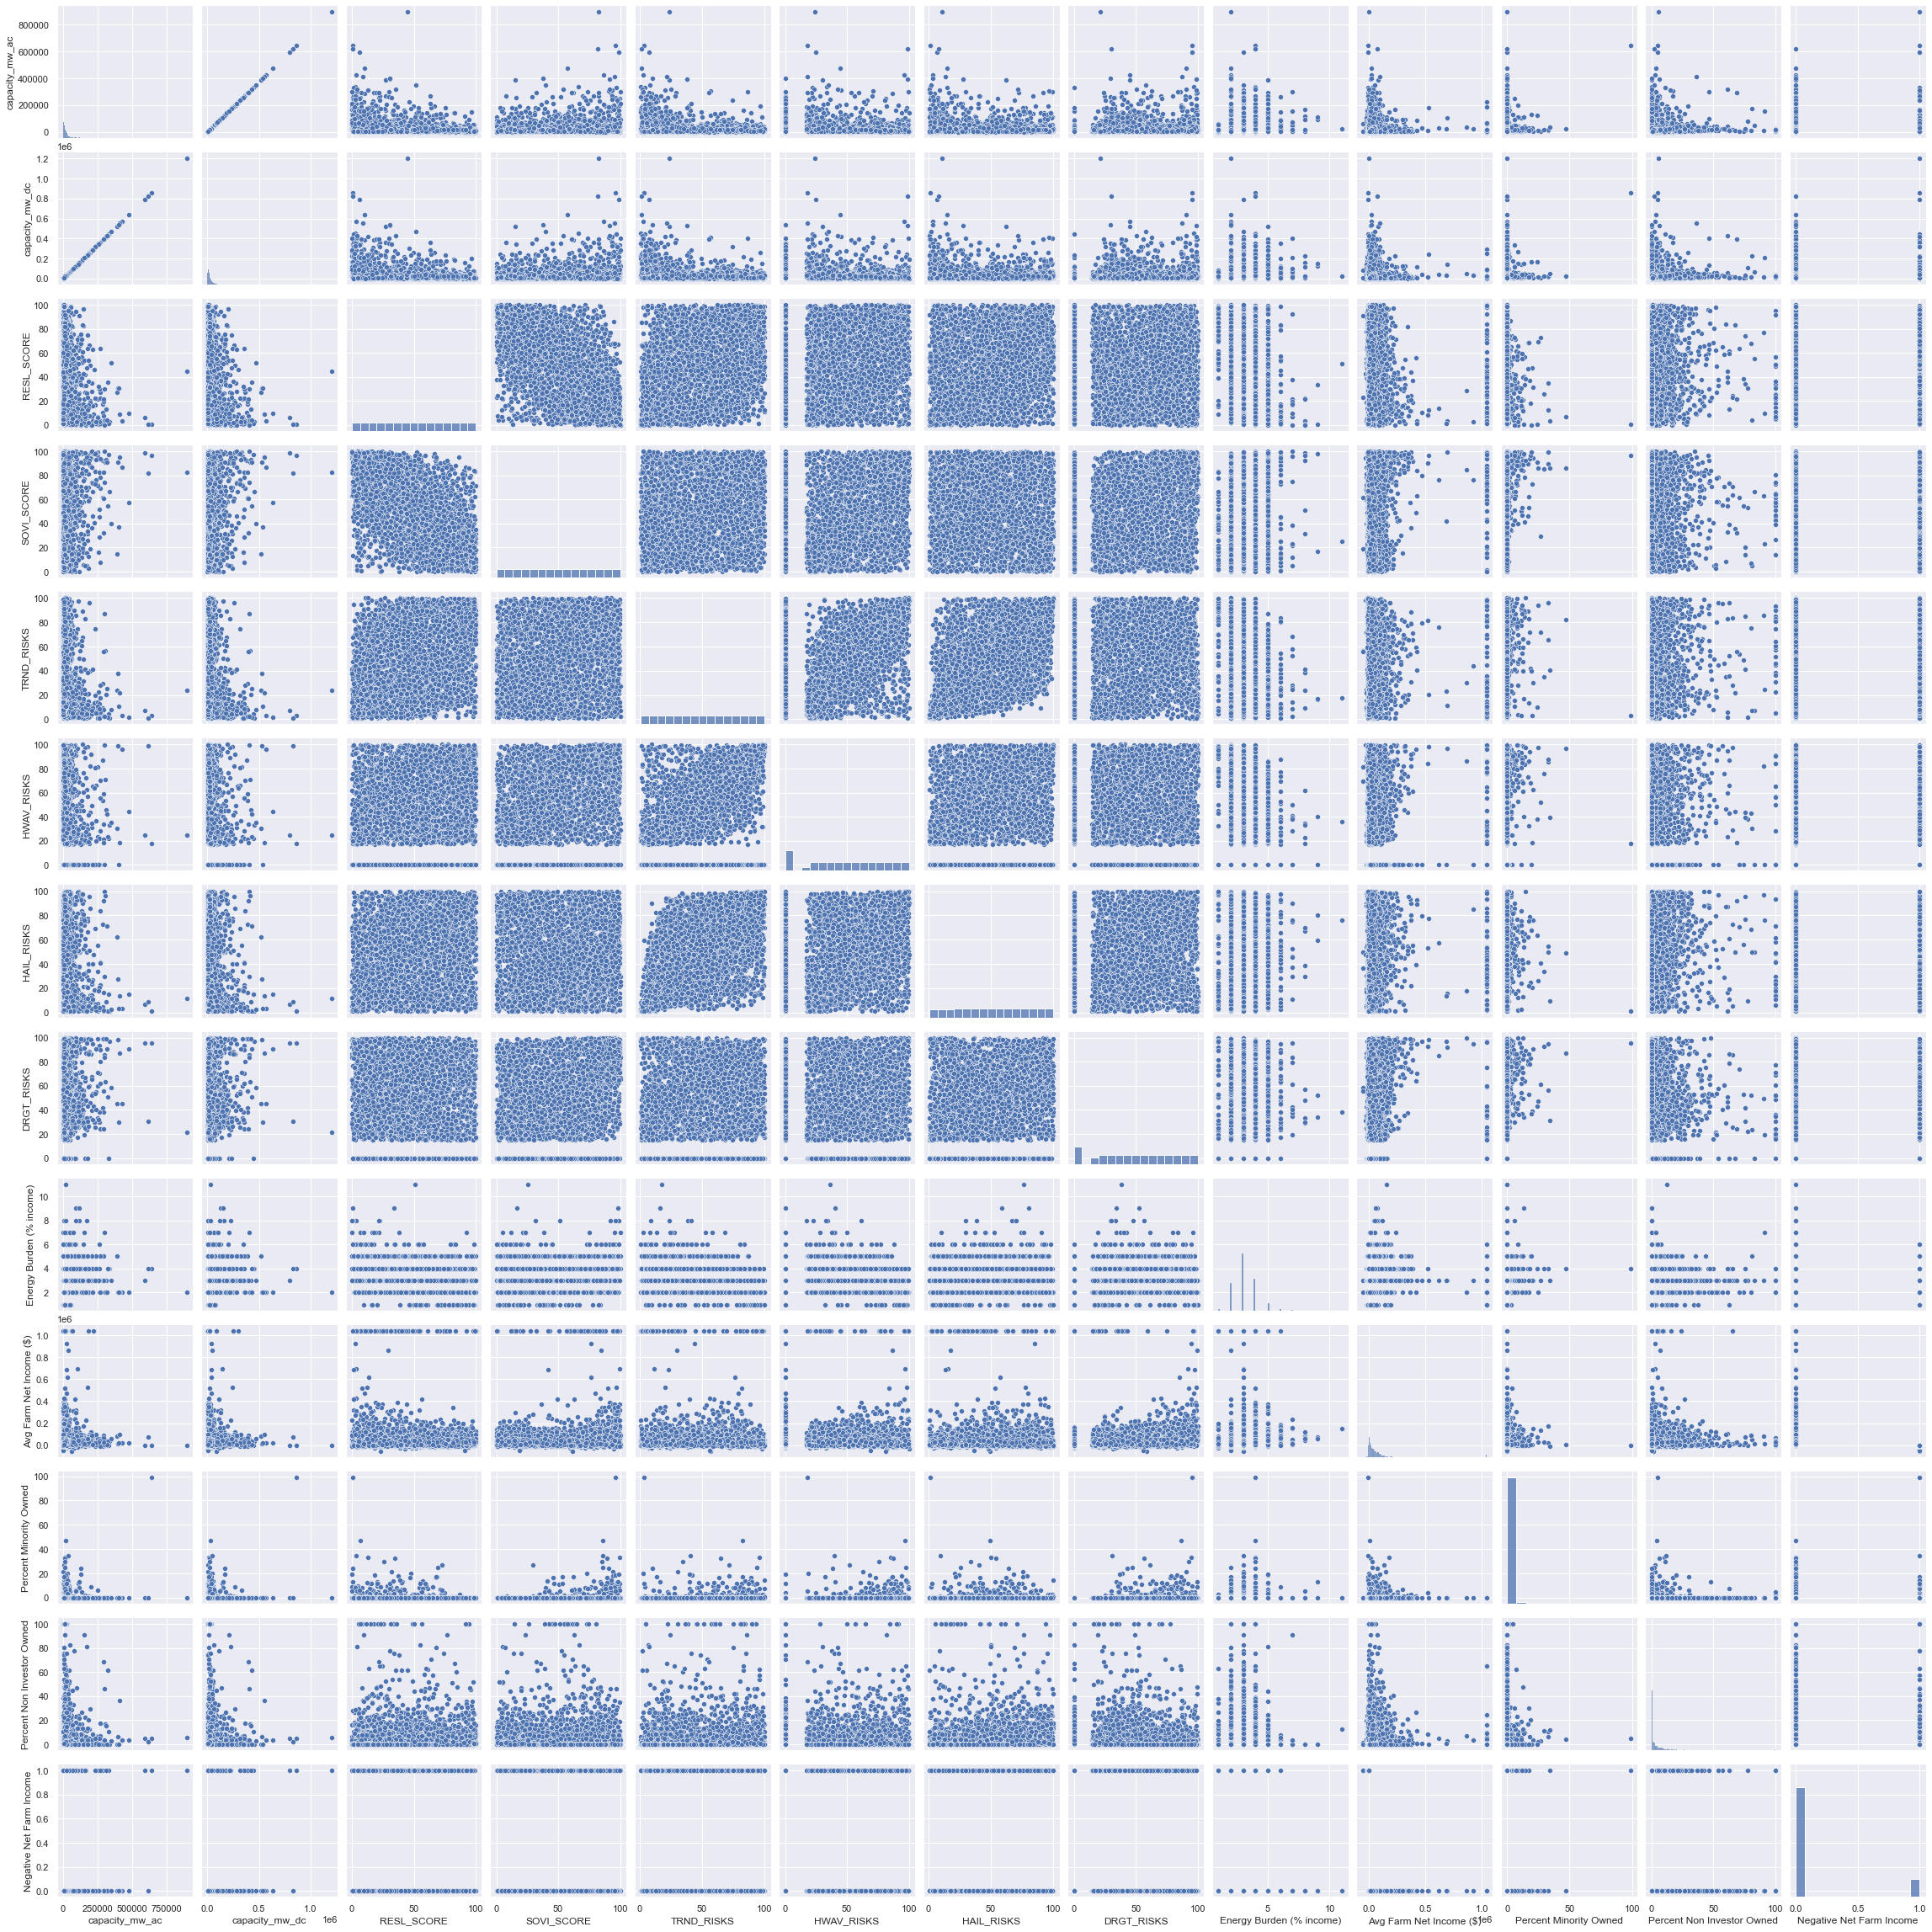

In [182]:
# only use one set of nri metric to make the graph comprehensible
sns.set_theme(style='darkgrid')
plot_cols = [col for col in merged_df.columns if '_RISKV' not in col and '_ALRA' not in col]
sns.pairplot(merged_df[plot_cols])

# save plot
graph_dir = 'AgPV_graphs'
graph_file = 'agpv_pairplot.png'
plt.savefig(os.path.join(graph_dir, graph_file))

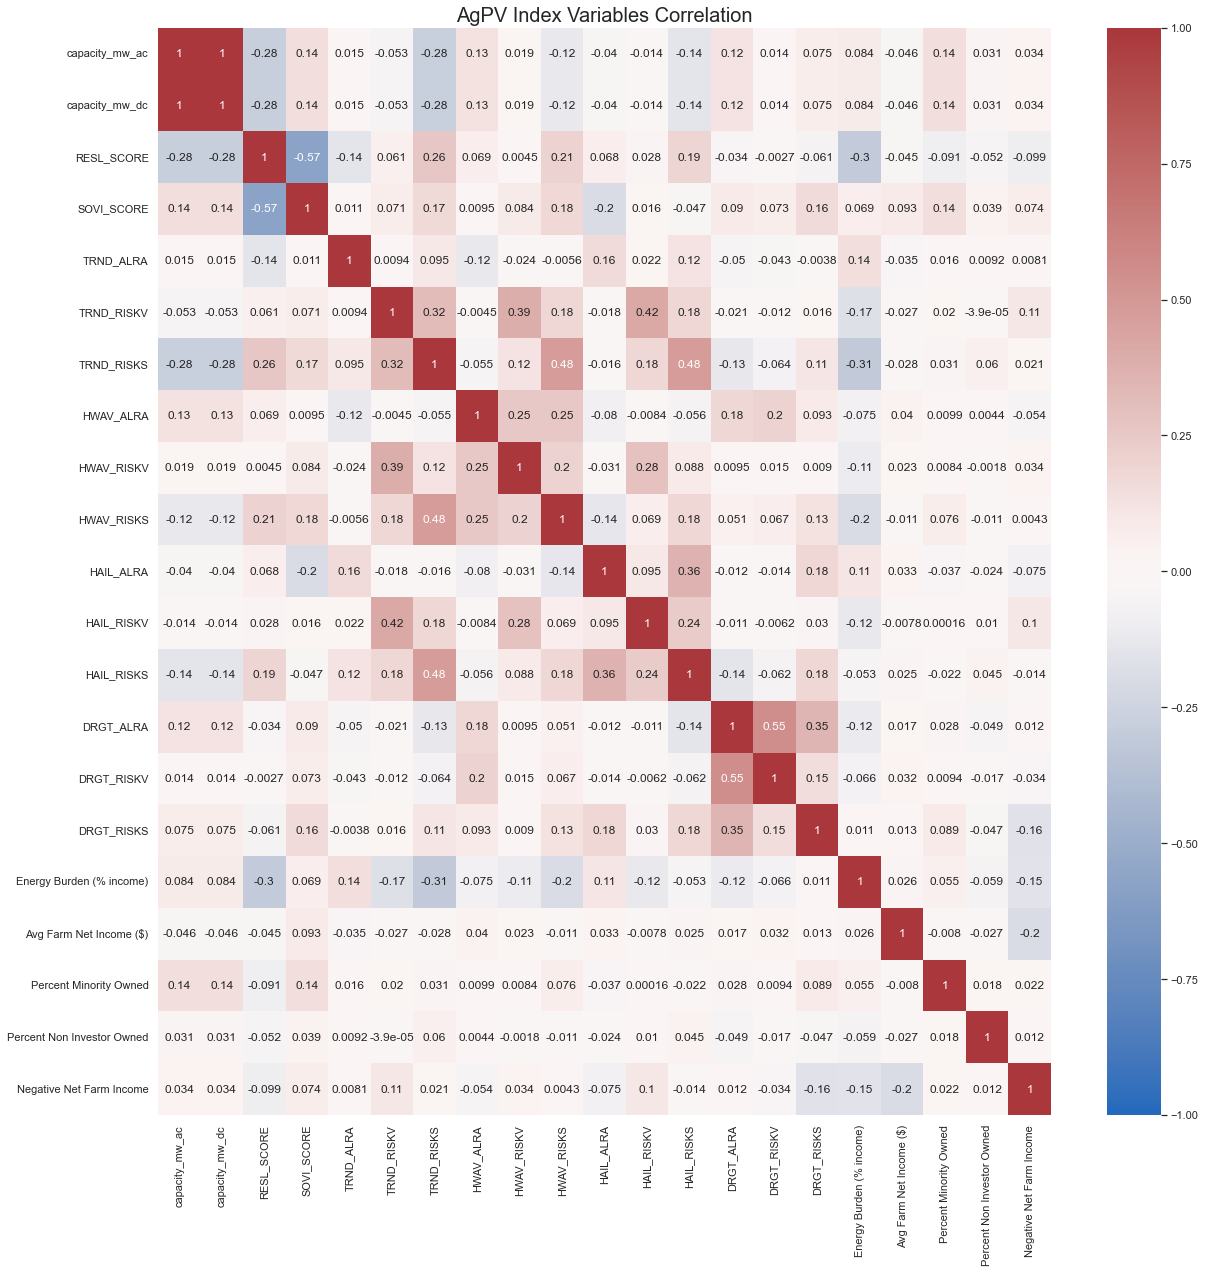

In [183]:
fig, ax = plt.subplots(figsize=(20,20))
corr_df = merged_df.iloc[:, 2:].corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Correlation', size=20)

# save file
corr_file = 'agpv_corr.png'
plt.savefig(os.path.join(graph_dir, corr_file))

## Index Preprocessing

NRI score values seem appropriate over using the value or expected loss metric since SVI and community resiliency also use score.

For roads to removal, I used a Box-Cox transform to try and fit to a normal distribution. This time, I'm trying quantile normalization, which really forces the data to a normal distribution. The results look much more gaussian. In a sense, it's mangling the data, but since we're already doing so much to it anyway with the scaling, it's probably OK. In most cases, we get very pretty bell curves.

Process:

* Transform underlying variables to fit normal dist'n
* Minmax scale data [0-1]
* Invert 'negative' variables (tornadoes and farmer income)
* Average values of underlying variables
* Minmax scal results [0-1]

In [184]:
# use quantile normalization to make everything have a normal distribution
from sklearn.preprocessing import quantile_transform, MinMaxScaler
X = quantile_transform(merged_df[plot_cols].iloc[:, 2:], output_distribution='normal')

# scale all values 0-1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# create df from transformed data
normalized_df = pd.DataFrame(X, columns=merged_df[plot_cols].iloc[:, 2:].columns, index=merged_df.index)
normalized_df = normalized_df.drop(columns=['capacity_mw_dc', 'Negative Net Farm Income'])

# need to invert the neagtives in the index: tornado risk and farm income
normalized_df['Avg Farm Net Income ($)'] = 1 - normalized_df['Avg Farm Net Income ($)']
normalized_df['TRND_RISKS'] = 1 - normalized_df['TRND_RISKS']
normalized_df.head()

capacity_mw_ac  RESL_SCORE  SOVI_SCORE  TRND_RISKS  HWAV_RISKS  \
FIPS                                                                    
01001        0.547606    0.504096    0.503589    0.440039    0.607810   
01003        0.612906    0.603788    0.453189    0.369846    0.628607   
01005        0.606443    0.352327    0.735681    0.439753    0.548137   
01007        0.570571    0.418034    0.584009    0.445549    0.541421   
01009        0.530352    0.428265    0.503724    0.379363    0.588573   

       HAIL_RISKS  DRGT_RISKS  Energy Burden (% income)  \
FIPS                                                      
01001    0.515519    0.499335                  0.488268   
01003    0.505205    0.606212                  0.387543   
01005    0.473010    0.581966                  0.580867   
01007    0.482337    0.452925                  0.580867   
01009    0.482416    0.503013                  0.488268   

       Avg Farm Net Income ($)  Percent Minority Owned  \
FIPS                                                     
01001                 0.524196                     0.0   
01003                 0.487156                     0.0   
01005                 0.445676                     0.0   
01007                 0.617746                     0.0   
01009                 0.439937                     0.0   

       Percent Non Investor Owned  
FIPS                               
01001                    0.531819  
01003                    0.593326  
01005                    0.555194  
01007                    0.531819  
01009                    0.000000

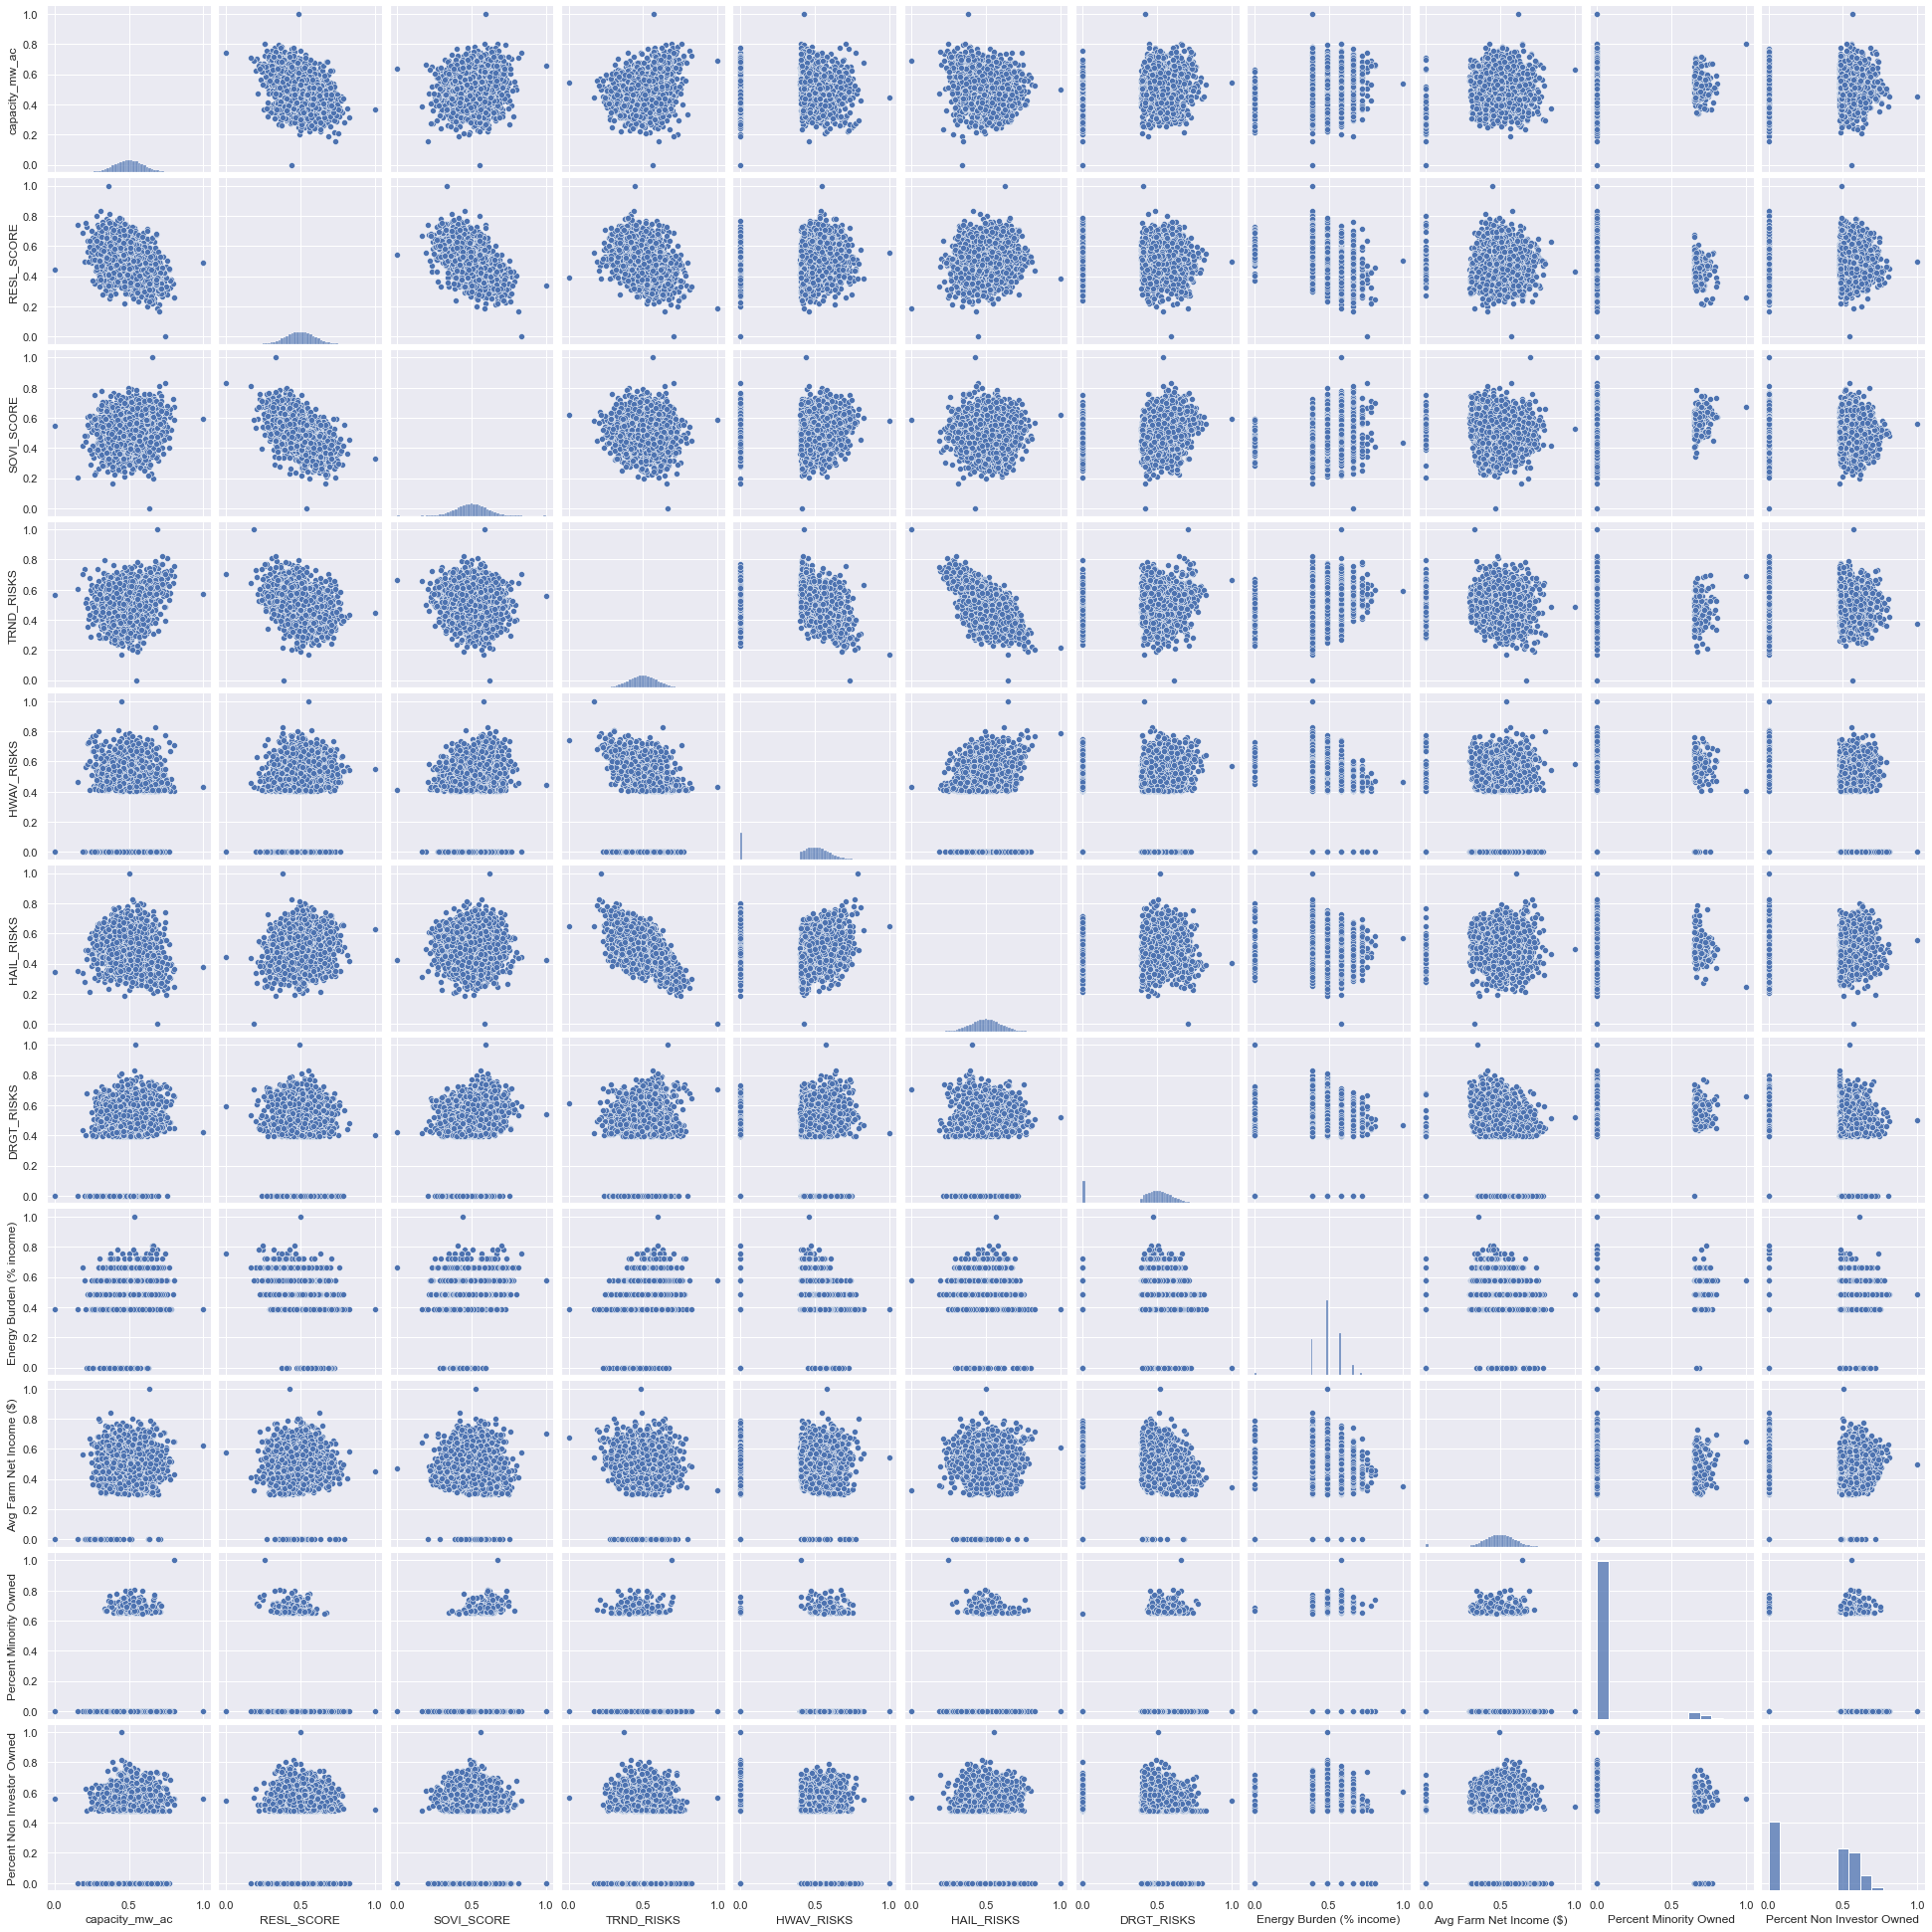

In [185]:
sns.pairplot(normalized_df)

The transformations seemed to slightly exagerate correlation between toranado and hail risk. Tornado and energy burden also have some correlation (0.3). This could cause some bias in the overall index.

Text(0.5, 1.0, 'AgPV Index Variables Quantile Transform Correlation')

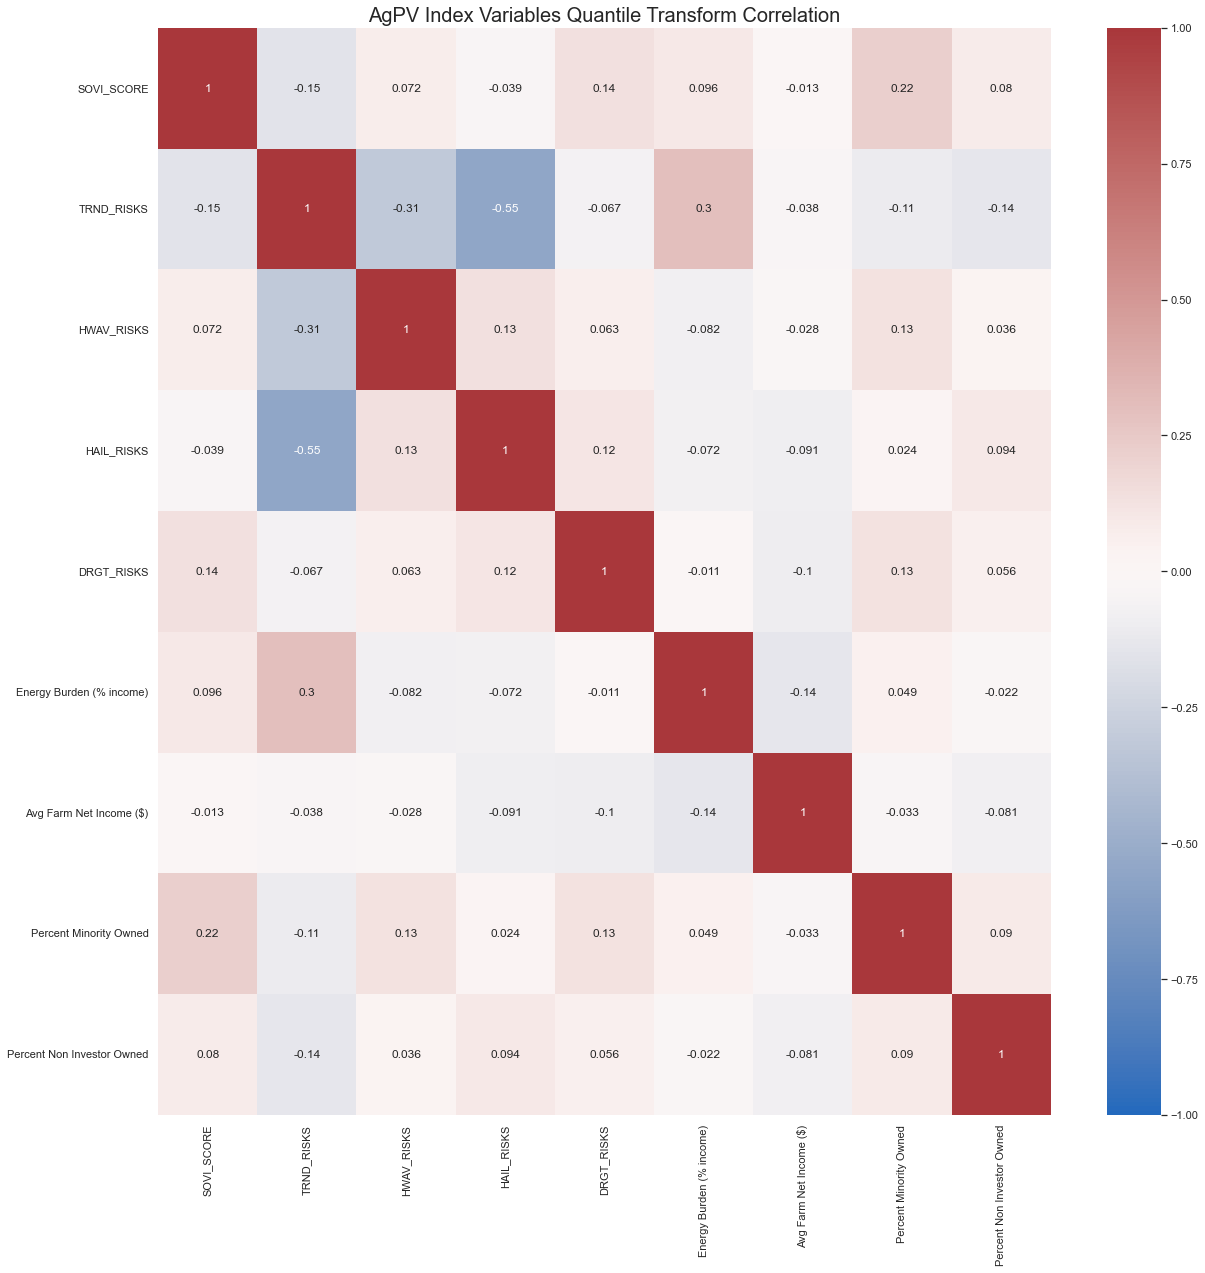

In [186]:
# correlation map with simplified variables and transformed
fig, ax = plt.subplots(figsize=(20,20))
corr_df = normalized_df.iloc[:, 2:].corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Quantile Transform Correlation', size=20)

In [187]:
# Get same columns from normalized df
plot_cols_df = merged_df[normalized_df.columns]
# scale un tranformed daata
scaled_original_data = scaler.fit_transform(plot_cols_df)
scaled_original_df = pd.DataFrame(scaled_original_data, index=plot_cols_df.index, columns=plot_cols_df.columns)
# add column to signify if this data has been quantile transformed
scaled_original_df['Quantile Transform'] = 'No'
# join dfs
xform_comp_df = pd.concat([scaled_original_df, normalized_df])
xform_comp_df['Quantile Transform'] = xform_comp_df['Quantile Transform'].fillna('Yes')
xform_comp_df = xform_comp_df.reset_index(drop=True)
xform_comp_df

capacity_mw_ac  RESL_SCORE  SOVI_SCORE  TRND_RISKS  HWAV_RISKS  \
0           0.024866    0.518100    0.513000    0.736031    0.870824   
1           0.052241    0.861200    0.310300    0.912974    0.910913   
2           0.048230    0.062400    0.992700    0.736994    0.697105   
3           0.031565    0.197300    0.807800    0.717084    0.672288   
4           0.020564    0.228200    0.513700    0.896275    0.824372   
...              ...         ...         ...         ...         ...   
6159        0.772800    0.451242    0.469834    0.626533    0.000000   
6160        0.414939    0.474309    0.417017    0.580958    0.000000   
6161        0.650273    0.443062    0.478016    0.615484    0.000000   
6162        0.642163    0.529358    0.440518    0.613263    0.000000   
6163        0.684579    0.374940    0.430232    0.569566    0.000000   

      HAIL_RISKS  DRGT_RISKS  Energy Burden (% income)  \
0       0.567255    0.506522                  0.200000   
1       0.525201    0.867961                  0.100000   
2       0.394543    0.806872                  0.300000   
3       0.431782    0.324213                  0.300000   
4       0.432103    0.521476                  0.200000   
...          ...         ...                       ...   
6159    0.309313    0.445549                  0.387543   
6160    0.470723    0.419487                  0.387543   
6161    0.407154    0.433134                  0.488268   
6162    0.332277    0.480902                  0.580867   
6163    0.566767    0.410947                  0.755007   

      Avg Farm Net Income ($)  Percent Minority Owned  \
0                    0.066971                     0.0   
1                    0.082619                     0.0   
2                    0.107769                     0.0   
3                    0.048795                     0.0   
4                    0.111314                     0.0   
...                       ...                     ...   
6159                 0.516124                     0.0   
6160                 0.564190                     0.0   
6161                 0.549482                     0.0   
6162                 0.501843                     0.0   
6163                 0.530308                     0.0   

      Percent Non Investor Owned Quantile Transform  
0                       0.029428                 No  
1                       0.096329                 No  
2                       0.046690                 No  
3                       0.029428                 No  
4                       0.000000                 No  
...                          ...                ...  
6159                    0.480934                Yes  
6160                    0.648862                Yes  
6161                    0.000000                Yes  
6162                    0.587595                Yes  
6163                    0.736407                Yes  

[6164 rows x 12 columns]

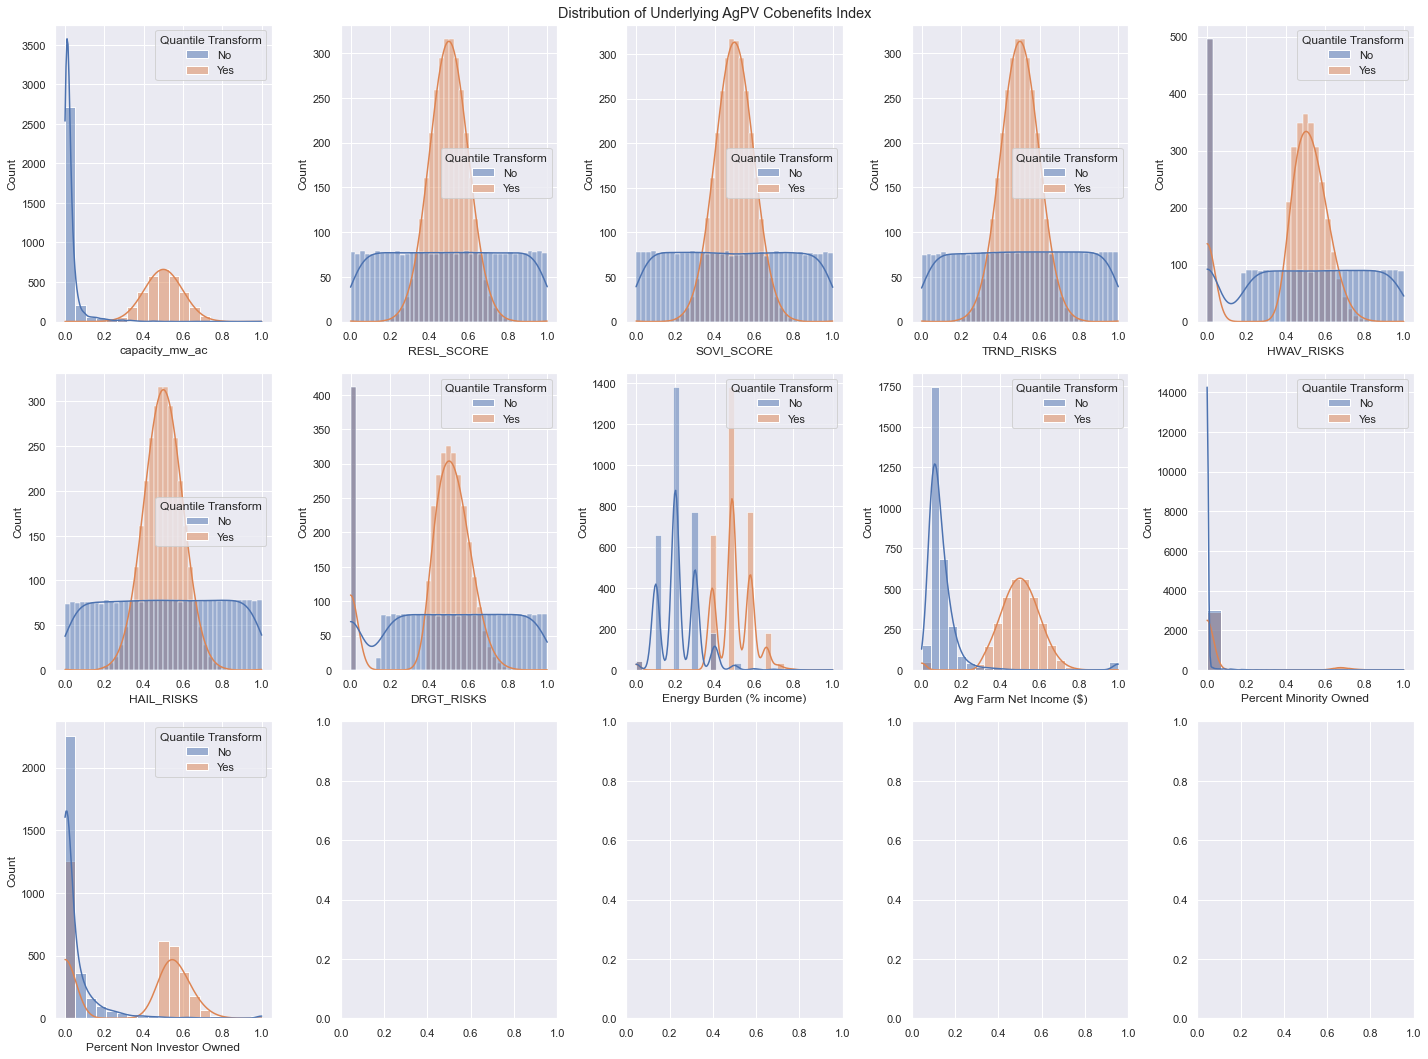

In [188]:
# look at histograms of transformed data compared to just minmax scaling. Look how beautiful these normal distributions are!
fig, axes = plt.subplots(3, 5, figsize=(20,15))

for col, ax in zip(xform_comp_df.iloc[:, :-1].columns, axes.flatten()):
    if col is not None:
        sns.histplot(xform_comp_df, x=col, kde=True, ax=ax, hue='Quantile Transform')
    
fig.suptitle('Distribution of Underlying AgPV Cobenefits Index')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_variable_distribution.png'))

Look at how wonderful those bell curves look!

### Ag PV Index Calculation

[Apache, AZ](https://en.wikipedia.org/wiki/Apache_County,_Arizona) stands out due to its near 100% minority cropland ownership, reasonably high energy burden (80th percentile), high drought risk (95th percentile), low torndo risk (2nd percentile), and high solar supply (99th percentile).

Most of this land is owned by the Navajo nation, so the high minoirty ownership is not suprising.

Also note that most of the top counties in overall index seem to have high social vulnerability as well. This makes sense, since climate hazards make up much of the underlying variables.


In [189]:
# get average of relevant variables
index_vars = ['capacity_mw_ac', 'TRND_RISKS', 'HWAV_RISKS', 'HAIL_RISKS', 'DRGT_RISKS', 'Energy Burden (% income)',
       'Avg Farm Net Income ($)', 'Percent Minority Owned', 'Percent Non Investor Owned']

# minmax scale final result
agpv_benefits_score = normalized_df[index_vars].mean(axis=1)
agpv_benefits_score = (agpv_benefits_score - agpv_benefits_score.min()) / (agpv_benefits_score.max() -agpv_benefits_score.min())

In [190]:
# merge calculated score with underlying data
score_df = pd.concat([merged_df, agpv_benefits_score], axis=1)
score_df = score_df.rename(columns={0:'AgPV_cobenefits_score'})

# filter relevant columns
score_df = score_df[plot_cols + ['AgPV_cobenefits_score']]
score_df = score_df.drop(columns=['capacity_mw_ac'])

# show top n counties
score_df.sort_values(['AgPV_cobenefits_score'], ascending=False).head(10)

county           state  capacity_mw_dc  RESL_SCORE  SOVI_SCORE  \
FIPS                                                                          
04001        Apache         Arizona   861473.520644    0.640000   96.500000   
45089  Williamsburg  South Carolina    24391.431228   18.299999   96.400002   
40135      Sequoyah        Oklahoma    26711.406422    7.100000   86.220001   
40107      Okfuskee        Oklahoma    29631.438316    9.930000   86.599998   
28051        Holmes     Mississippi    37029.755147    2.450000   99.199997   
45049       Hampton  South Carolina    19933.842930   25.940001   85.300003   
30003      Big Horn         Montana   286945.858399   16.100000   66.610001   
30085     Roosevelt         Montana   151921.498082    2.480000   79.540001   
01053      Escambia         Alabama    56344.178925   20.590000   87.080002   
04021         Pinal         Arizona    10686.080830   20.690001   83.769997   

       TRND_RISKS  HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  \
FIPS                                                    
04001    3.372574   17.817372    1.336303   95.259306   
45089   41.679924   68.215081   24.435253   83.041680   
40135   82.278078   96.531976   49.156857   86.859688   
40107   41.552657   89.818645   70.601336   60.610881   
28051   80.464524   73.401209   57.429208   77.760102   
45049   34.902959   75.660197   33.662106   92.491250   
30003   11.135857   65.128858   27.139675   53.897550   
30085   28.030544   68.978683   37.639198   45.752466   
01053   79.128221   94.082087   31.244034   80.464524   
04021   39.961820   98.822781   12.790328   99.618199   

       Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                       
04001                       4.0                  -4575.0   
45089                       5.0                   6503.0   
40135                       4.0                   6279.0   
40107                       4.0                  -5160.0   
28051                       6.0                  14598.0   
45049                       4.0                  30332.0   
30003                       5.0                  47106.0   
30085                       4.0                  28445.0   
01053                       4.0                   -536.0   
04021                       3.0                 128381.0   

       Percent Minority Owned  Percent Non Investor Owned  \
FIPS                                                        
04001               98.988622                    5.192231   
45089               18.540245                   20.155630   
40135               47.188558                    4.240910   
40107                0.641849                    4.360075   
28051                8.730331                    7.855864   
45049               29.707419                   11.155606   
30003                0.454442                    5.403757   
30085                8.338451                   16.798929   
01053                9.563887                    2.955812   
04021               12.799600                   47.652262   

       Negative Net Farm Income  AgPV_cobenefits_score  
FIPS                                                    
04001                         1               1.000000  
45089                         0               0.914125  
40135                         0               0.911116  
40107                         1               0.908878  
28051                         0               0.900925  
45049                         0               0.899020  
30003                         0               0.896001  
30085                         0               0.891840  
01053                         1               0.891785  
04021                         0               0.890086

In [191]:
score_df.sort_values(['AgPV_cobenefits_score'], ascending=False).rank(pct=True).head()

county     state  capacity_mw_dc  RESL_SCORE  SOVI_SCORE  TRND_RISKS  \
FIPS                                                                            
04001  0.022713  0.024335        0.999676    0.006814    0.964958    0.024010   
45089  0.975990  0.746755        0.617132    0.182998    0.963984    0.406230   
40135  0.818624  0.691759        0.648605    0.071382    0.863076    0.819598   
40107  0.674886  0.691759        0.686243    0.098962    0.866321    0.404932   
28051  0.408501  0.456035        0.757625    0.024984    0.992213    0.801103   

       HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  Energy Burden (% income)  \
FIPS                                                                  
04001    0.167748    0.004543    0.951655                  0.799643   
45089    0.676509    0.233615    0.827060                  0.953764   
40135    0.964958    0.483128    0.865996                  0.799643   
40107    0.896496    0.700519    0.598313                  0.799643   
28051    0.729396    0.567489    0.773199                  0.988968   

       Avg Farm Net Income ($)  Percent Minority Owned  \
FIPS                                                     
04001                 0.059377                1.000000   
45089                 0.254056                0.996106   
40135                 0.249189                0.999676   
40107                 0.050941                0.951979   
28051                 0.359507                0.986372   

       Percent Non Investor Owned  Negative Net Farm Income  \
FIPS                                                          
04001                    0.730857                  0.928942   
45089                    0.927644                  0.428942   
40135                    0.695977                  0.428942   
40107                    0.702141                  0.928942   
28051                    0.801265                  0.428942   

       AgPV_cobenefits_score  
FIPS                          
04001               1.000000  
45089               0.999676  
40135               0.999351  
40107               0.999027  
28051               0.998702

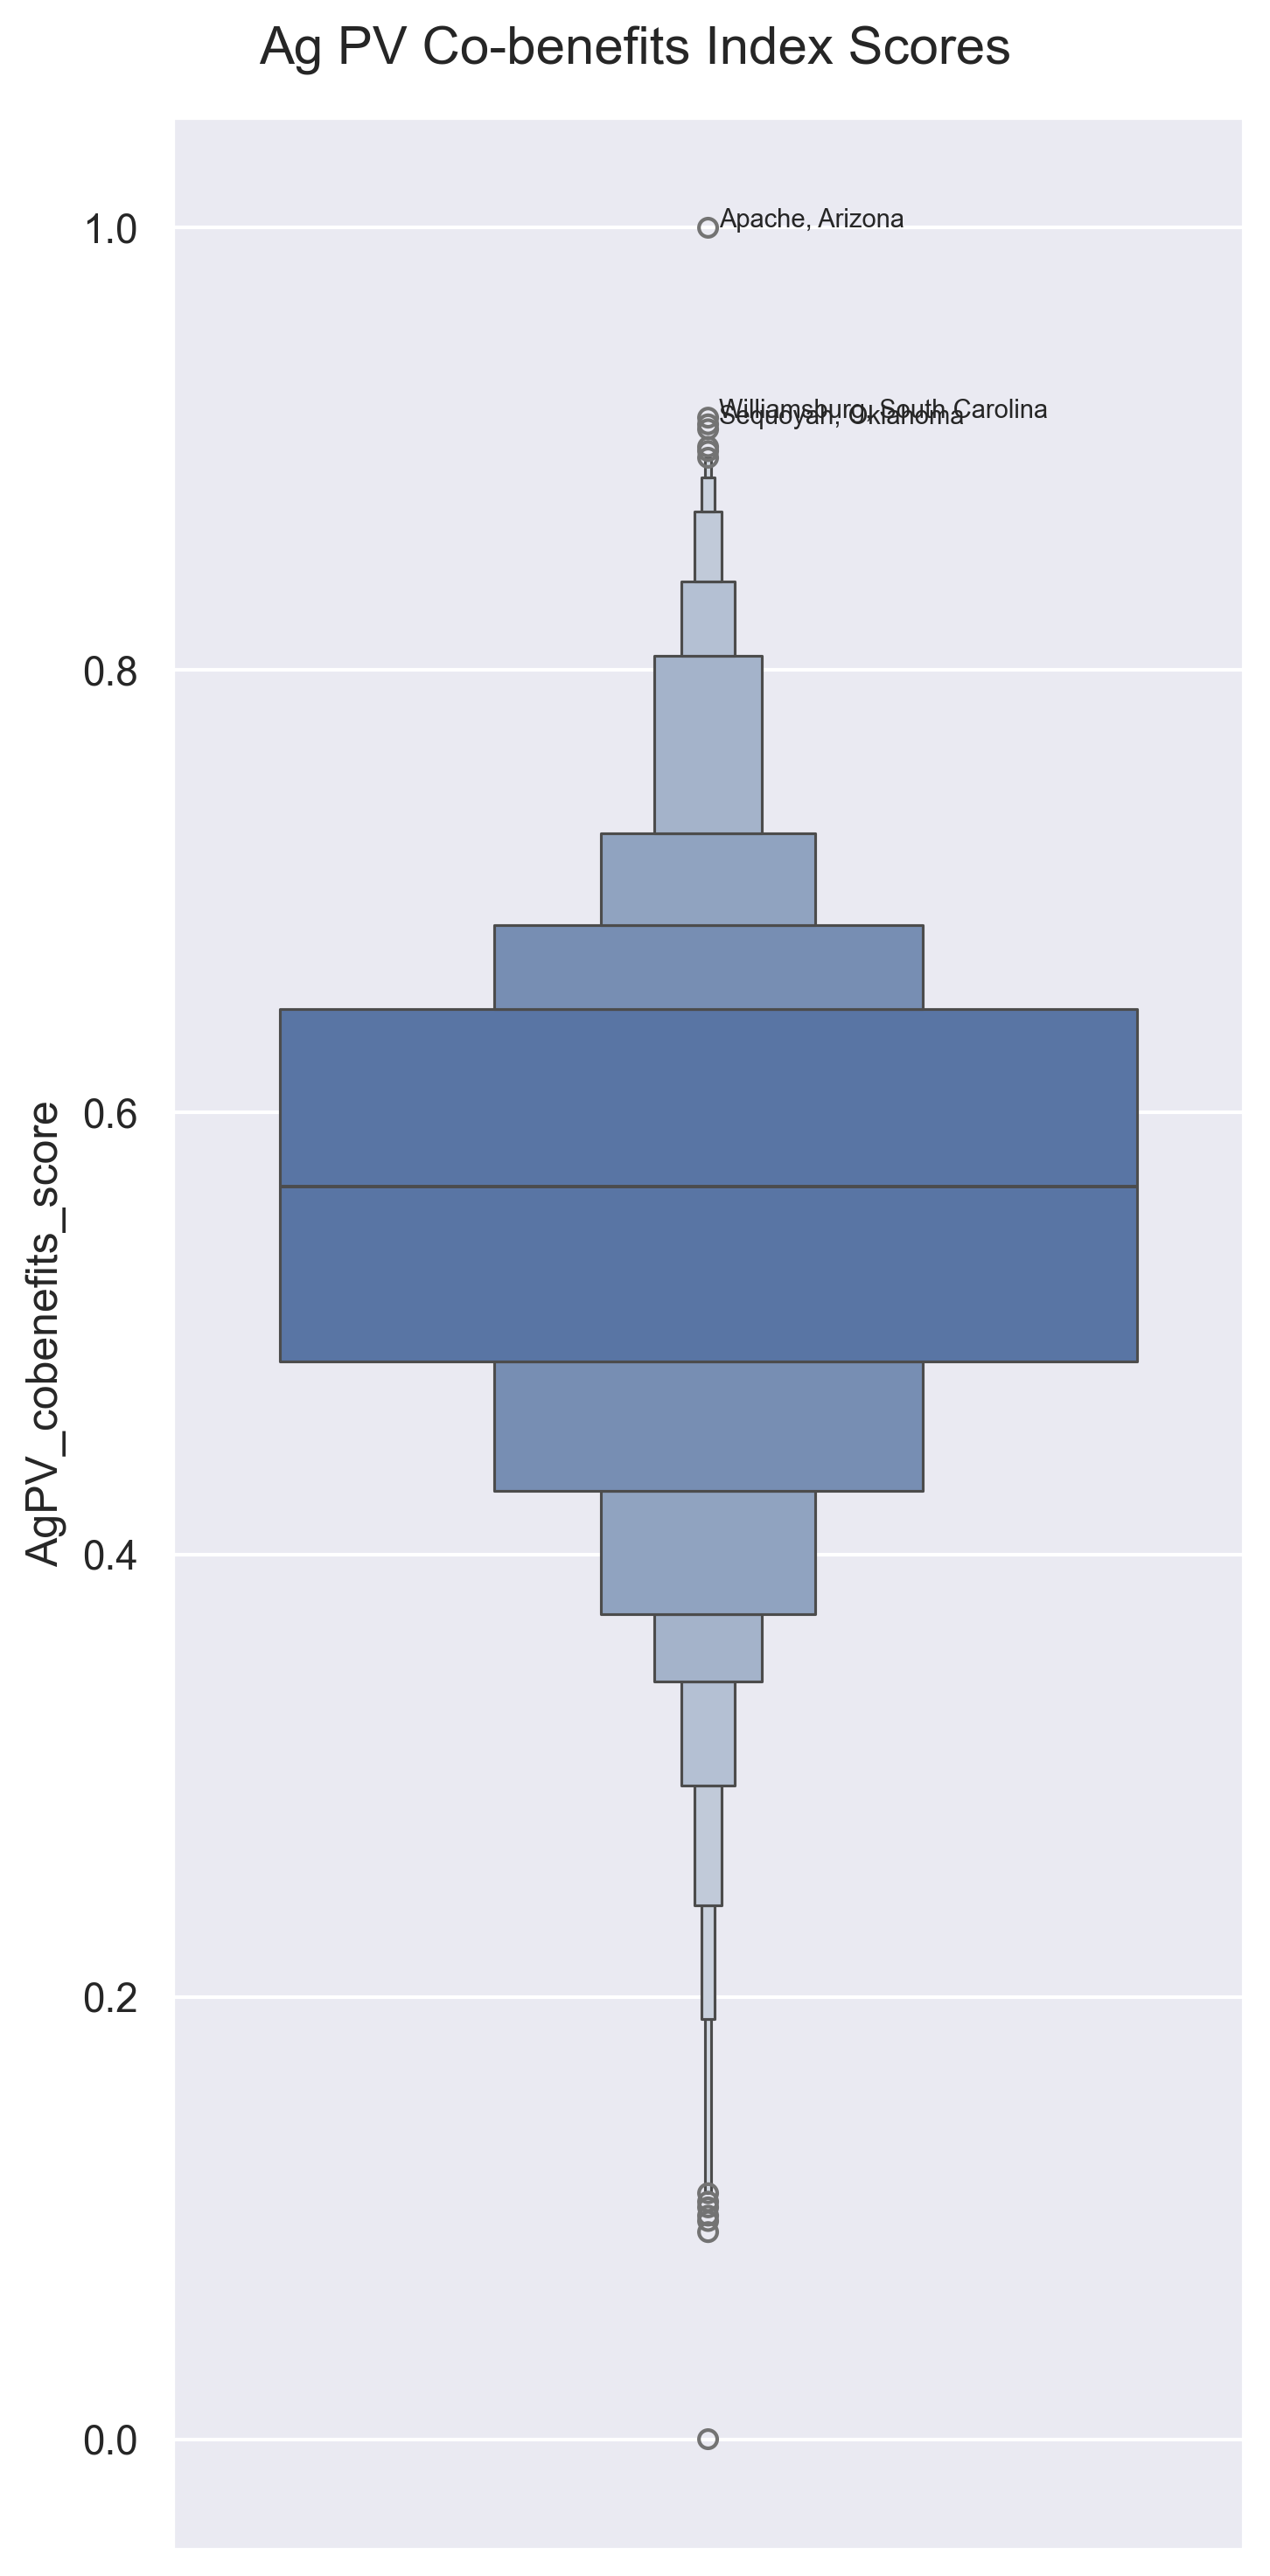

In [192]:
fig, ax = plt.subplots(1,1, figsize=(5,10), dpi=300)
g = sns.boxenplot(score_df, y='AgPV_cobenefits_score')

# annotate top n outliers
def annotate_outliers(row, g):
    text = ', '.join([row['county'], row['state']])
    y = row['AgPV_cobenefits_score']
    g.annotate(text, xy=(0.01, y), ha='left', size=7)
    
score_df.sort_values('AgPV_cobenefits_score', ascending=False).iloc[:3].apply(lambda x: annotate_outliers(x, g), axis=1)

fig.suptitle('Ag PV Co-benefits Index Scores')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_score_boxen.png'))

## Clustering
Let's do some simple unsupervised learning on this data set. Maybe using clusters can provide more nuaced themes and analysis for groups that a single number might overlook.

This [post](https://medium.com/@jackiee.jecksom/clustering-and-principal-component-analysis-pca-from-sklearn-c8ea5fed6648) has some cool visualization ideas: 

<Axes: >

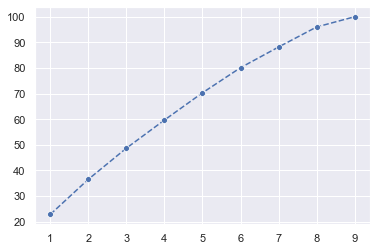

In [193]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# normalize data
X_norm = StandardScaler().fit_transform(merged_df[index_vars])

# principal component analysis
pca = PCA()
pca.fit(X_norm)
# get percent variance explained
percent_var = np.round(pca.explained_variance_ratio_ * 100, 3)

sns.lineplot(x=range(1, len(percent_var) + 1), y=percent_var.cumsum(), marker='o', linestyle='--')

Without quantile normaization, 6 principle components explain ~80% of the variance. This seems like a good number to choose.

In [194]:
n_comps=6
pca = PCA(n_components=n_comps)
pca.fit(X_norm)
scores_pca = pca.transform(X_norm)

k_values = range(2,21)
# clustering
WCSS = [] # holds within cluster sum of squares for eack value of k

for k in k_values:
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
    kmeans_pca.fit(scores_pca)
    WCSS.append(kmeans_pca.inertia_)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

Text(0, 0.5, 'WCSS')

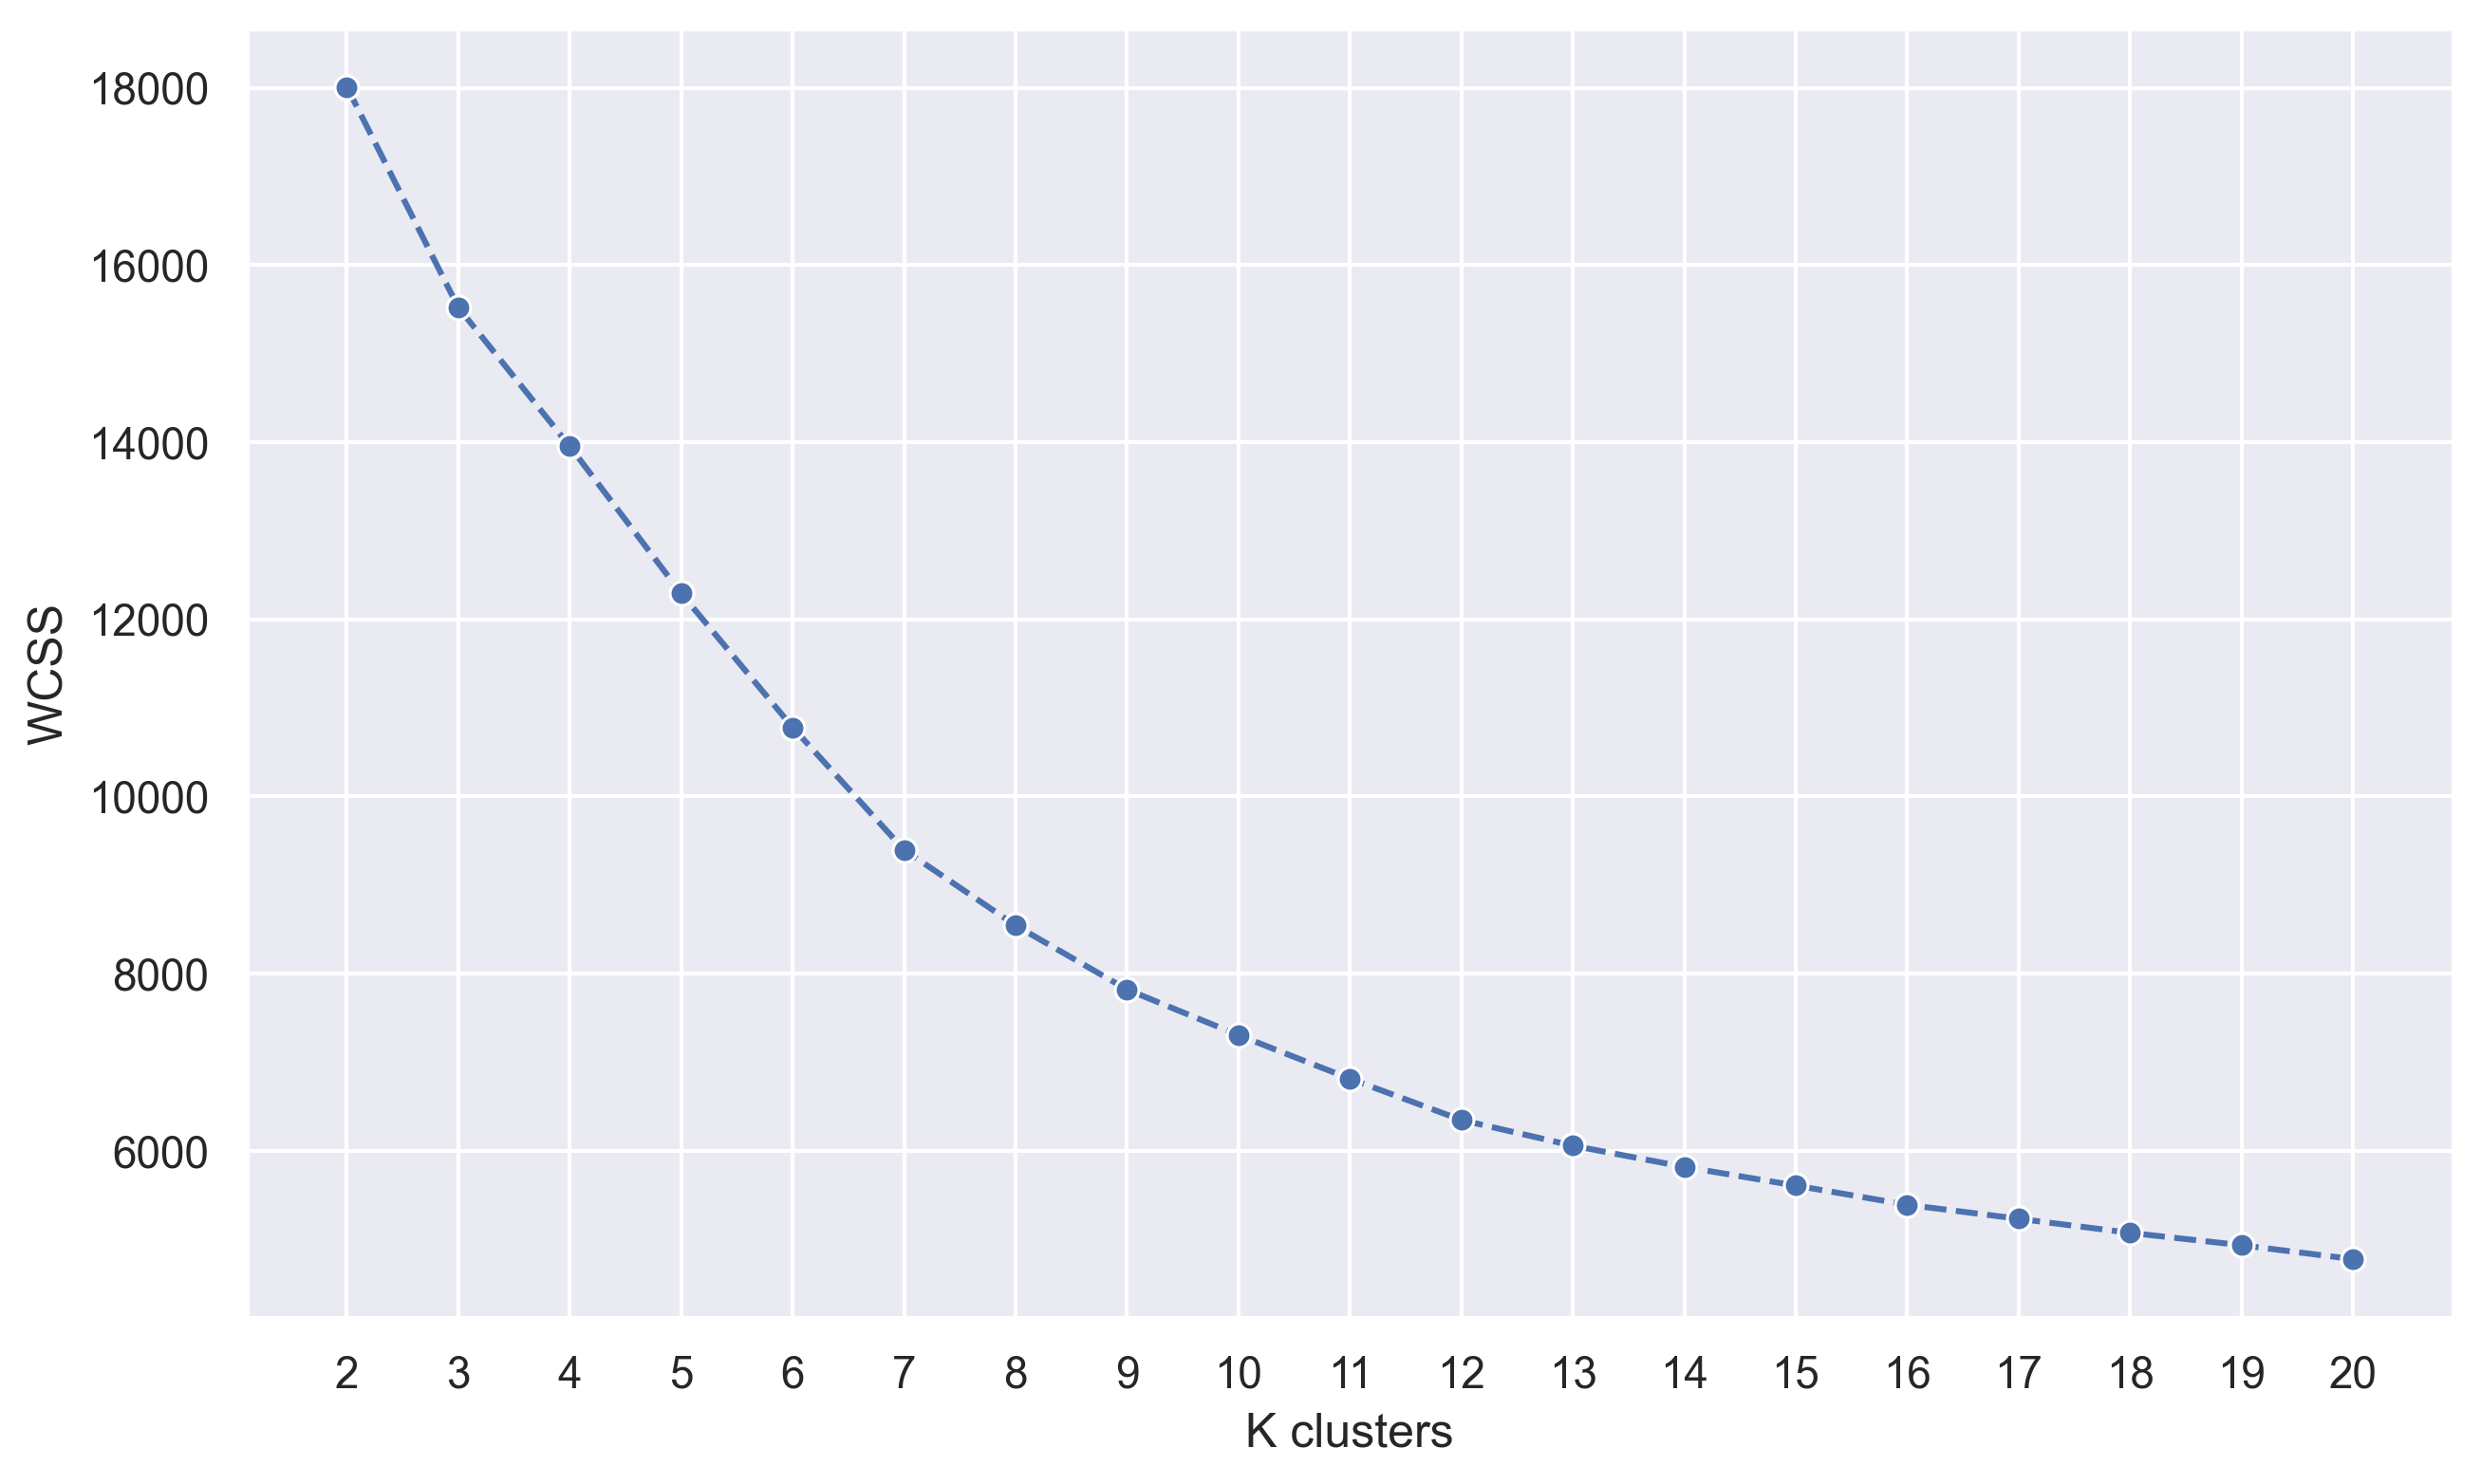

In [195]:
plt.figure(figsize=(10,6), dpi=300)
g = sns.lineplot(x=k_values, y=WCSS, marker='o', linestyle='--')
g.set_xticks(k_values)
g.set_xlabel('K clusters')
g.set_ylabel('WCSS')

There's no clear elbow point. K=8 or 9 seems like there's a slight change in slope of the line. Using silhoutte score might give more detail. Let's use 8 for now.

In [196]:
k = 8
kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
kmeans_pca.fit(scores_pca)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(random_state=123)

In [197]:
# Add pricipal components to original df
pc_col_names = ['PC' + str(k + 1) for k in range(n_comps)]
cluster_df = pd.concat([merged_df[index_vars], pd.DataFrame(scores_pca, columns=pc_col_names, index=merged_df.index)], axis=1)

# add labels from kmeans
cluster_df['Cluster'] = kmeans_pca.labels_
cluster_df['Cluster'] = cluster_df['Cluster'].astype(str)
cluster_df

capacity_mw_ac  TRND_RISKS  HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  \
FIPS                                                                    
01001    22349.202978   73.846643   87.082405   57.111040   50.652243   
01003    46948.973155   91.377665   91.091314   52.943048   86.796055   
01005    43344.657028   73.942094   69.710468   39.993637   80.687241   
01007    28368.690972   71.969456   67.228762   43.684378   32.421254   
01009    18483.385380   89.723194   82.437162   43.716195   52.147630   
...               ...         ...         ...         ...         ...   
56037   401041.398994   10.531339    0.000000    3.340757   29.812281   
56039     4915.661374   21.189946    0.000000   39.102768   21.539930   
56041    83816.558073   12.567611    0.000000   17.817372   25.676106   
56043    72277.627225   13.013045    0.000000    5.058861   43.143493   
56045   155044.608219   24.657970    0.000000   76.073815   19.153675   

       Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                       
01001                       3.0                  18279.0   
01003                       2.0                  35436.0   
01005                       4.0                  63011.0   
01007                       4.0                  -1650.0   
01009                       3.0                  66897.0   
...                         ...                      ...   
56037                       2.0                  21628.0   
56039                       2.0                   6411.0   
56041                       3.0                  10310.0   
56043                       4.0                  28058.0   
56045                       7.0                  15943.0   

       Percent Minority Owned  Percent Non Investor Owned       PC1       PC2  \
FIPS                                                                            
01001                     0.0                    2.942734 -1.251089  0.065357   
01003                     0.0                    9.632698 -2.033800  0.736389   
01005                     0.0                    4.668915 -0.456643  0.883871   
01007                     0.0                    2.942734 -0.239708 -0.132495   
01009                     0.0                    0.000000 -1.326469 -0.032452   
...                       ...                         ...       ...       ...   
56037                     0.0                    0.003478  4.239231  2.607267   
56039                     0.0                   22.753224  1.146620 -1.372627   
56041                     0.0                    0.000000  2.501858 -0.318176   
56043                     0.0                    8.685847  2.812572  0.030479   
56045                     0.0                   91.119574  2.699421  1.103475   

            PC3       PC4       PC5       PC6 Cluster  
FIPS                                                   
01001  0.143379 -0.573201  0.052323  0.091163       1  
01003  0.652831 -0.358937  0.239813 -1.167045       1  
01005 -0.418556 -0.146732 -0.289655 -0.130845       6  
01007  0.067168 -0.444117 -0.230733  0.801531       1  
01009 -0.085142 -0.678951  0.421677  0.051055       1  
...         ...       ...       ...       ...     ...  
56037  2.652927 -0.721956  0.921309 -3.824650       3  
56039  1.491208  0.794666 -0.040936 -0.270627       0  
56041  0.569458 -0.541077  0.110337 -0.528963       0  
56043  0.378604  0.105523 -0.244252 -0.210521       0  
56045  3.088783  6.333847 -2.818256  1.315805       4  

[3082 rows x 16 columns]

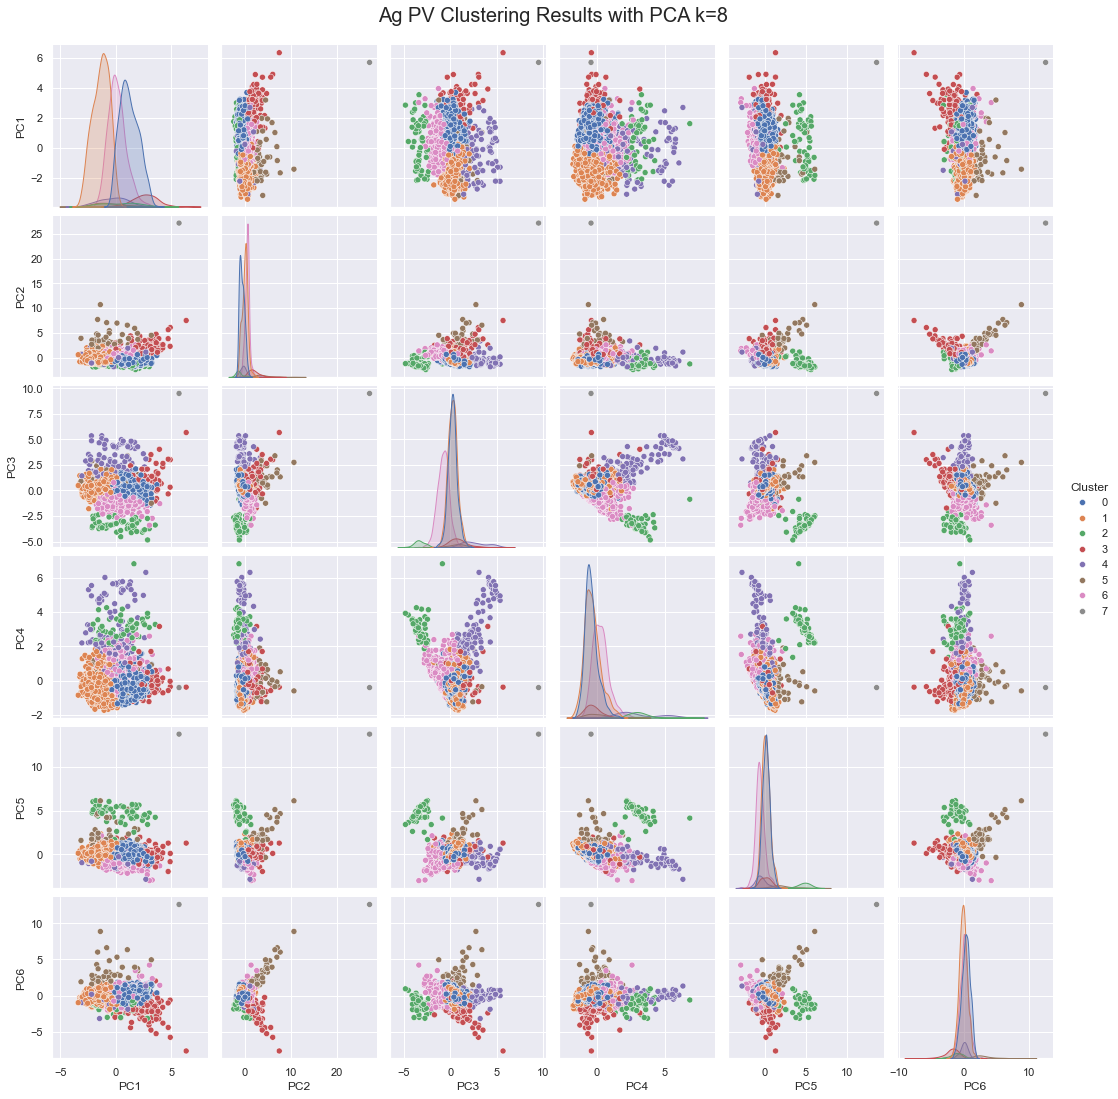

In [214]:
sns.pairplot(cluster_df.iloc[:,-n_comps-1:], hue='Cluster', hue_order=sorted(cluster_df['Cluster'].unique()))
plt.suptitle('Ag PV Clustering Results with PCA k=8', size=20, y=1.02)
plt.savefig(os.path.join(graph_dir, 'agpv_pca_clustering.png'))

## Clustering Analysis
Most of the results seem jumbled together, but there's a few groups that stand out.

* Cluster 2 has clear separation in a few of the views.
* Cluster 4 also gets some separation
* Cluster 7 only has 1 point, but it is a clear outlier from everything else. I bet this is Apache, AZ
* The purple cluster (cluster 3) seems to be closer to cluster 7 than the other clusters

Let's have a look at the clusters:

In [201]:
cluster_summary = cluster_df.groupby(['Cluster']).mean().round(2)
# drop pc values
cluster_summary = cluster_summary.loc[:, :'Percent Non Investor Owned']
cluster_summary

capacity_mw_ac  TRND_RISKS  HWAV_RISKS  HAIL_RISKS  DRGT_RISKS  \
Cluster                                                                   
0              20240.75       30.12       32.28       28.62       26.93   
1              16599.56       76.41       72.58       62.99       52.97   
2              16339.48       44.07       44.14       40.17       24.39   
3             212936.93       12.26       30.09       21.29       65.60   
4              33185.13       52.57       47.43       53.54       41.79   
5              26760.49       63.50       73.75       49.74       68.42   
6              22248.92       46.39       40.66       64.31       70.70   
7             642890.58        3.37       17.82        1.34       95.26   

         Energy Burden (% income)  Avg Farm Net Income ($)  \
Cluster                                                      
0                            3.29                 25514.10   
1                            2.56                 35841.45   
2                            2.75               1016329.11   
3                            3.36                 44876.41   
4                            2.95                 36720.93   
5                            3.71                 54770.33   
6                            3.87                 82340.16   
7                            4.00                 -4575.00   

         Percent Minority Owned  Percent Non Investor Owned  
Cluster                                                      
0                          0.01                        2.92  
1                          0.19                        4.85  
2                          0.00                        2.90  
3                          0.25                        3.89  
4                          0.15                       58.41  
5                         16.73                        7.09  
6                          0.12                        3.69  
7                         98.99                        5.19

Cluster 7 is Apache AZ. High minority cropland ownership!

Cluster 4 is defined by it's high solar potential
Cluster 2 has high Avg Farm Net income
Cluster 6: high tornado risk

In [73]:
score_df.to_csv('agpv_cobenefits_index.csv')